# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of Briefing: Drivers behind the geographic concentration on Airbnb listings across London

### Student ID: 21203086 

### Word Count: 1490

# Reproducible Analysis

## Introduction-overview

This notebook holds the analysis for the classification of Airbnb penetration in London.
After a first exploration of the datasets with visualisations that seek to quantify the current picture of Airbnb listings in London, the London wards are classified by their amount of listings (low, medium, high), followed by a geodemographic classification of the London Wards that attempts to identify patterns explaining the presence or absence of listings.


Data used for this analysis were obtained from the following sources:
* Airbnb listings, compiled 10 October 2021: <http://insideairbnb.com/get-the-data.html>
* London Wards data: <https://data.london.gov.uk/dataset/ward-profiles-and-atlas>
* London Boroughs and Wards geography: <https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london>

For ease of access the data has been saved in the following github repository: <https://github.com/DaphneBdn/fsds_cw3> 

## Libraries

In [1]:
# import the main libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

## Data import

### London Boundary 

First create a background map of London that can be used for visualisations.

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

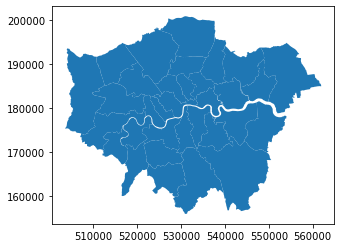

In [2]:
# Read the London Boroughs geopackage 

boros = gpd.read_file('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/geo/Boroughs.gpkg?raw=true')
boros.plot()

In [3]:
# Convert to a geodataframe by setting the CRS to the British National grid with EPSG 27700
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

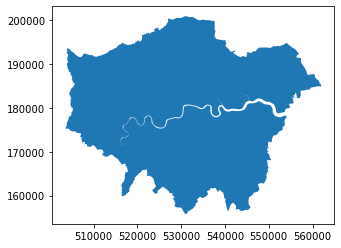

In [4]:
# Create the London shape (for later use)
ldn['geometry'] = ldn.original.buffer(20)
ldn_shape = ldn.set_geometry('geometry')
ldn_shape.plot();

### Airbnb Data

The London Airbnb listigns data set used here is the latest from [Inside Airbnb](http://insideairbnb.com/get-the-data.html), which according to the website was compiled on 10 October, 2021.

In [5]:
# Load in the Airbnb data 
df = pd.read_csv('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/raw/listings.csv.gz?raw=true', compression='gzip')
df.head(3)

id                         listing_url       scrape_id last_scraped  \
0  13913  https://www.airbnb.com/rooms/13913  20211010233627   2021-10-12   
1  15400  https://www.airbnb.com/rooms/15400  20211010233627   2021-10-12   
2  17402  https://www.airbnb.com/rooms/17402  20211010233627   2021-10-12   

                                    name  \
0    Holiday London DB Room Let-on going   
1    Bright Chelsea  Apartment. Chelsea!   
2  Superb 3-Bed/2 Bath & Wifi: Trendy W1   

                                         description  \
0  My bright double bedroom with a large window h...   
1  Lots of windows and light.  St Luke's Gardens ...   
2  You'll have a wonderful stay in this superb mo...   

                               neighborhood_overview  \
0  Finsbury Park is a friendly melting pot commun...   
1                                     It is Chelsea.   
2  Location, location, location! You won't find b...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/miso/Hosting-...    54730   
1  https://a0.muscache.com/pictures/428392/462d26...    60302   
2  https://a0.muscache.com/pictures/39d5309d-fba7...    67564   

                                  host_url  ... review_scores_communication  \
0  https://www.airbnb.com/users/show/54730  ...                        4.89   
1  https://www.airbnb.com/users/show/60302  ...                        4.82   
2  https://www.airbnb.com/users/show/67564  ...                        4.66   

  review_scores_location review_scores_value license instant_bookable  \
0                   4.63                4.74     NaN                f   
1                   4.93                4.73     NaN                f   
2                   4.85                4.59     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              2                                           1   
1                              1                                           1   
2                              2                                           2   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            0   
2                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.17  
1                                           0              0.79  
2                                           0              0.35  

[3 rows x 74 columns]

In [6]:
# extract the column names
cols=df.columns
print(cols)
print()
print(f"The Inside Airbnb dataset has {len(cols)} columns")

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Reducing the number of columns to make the dataset more manageable and to get a better overview. Prepare the data for the first exploration and summary statistics.

In [7]:
# store the columns of interest in a list
sub_cols=['id', 'name','latitude','longitude', 'property_type', 'room_type', 'price',
          'availability_365', 'number_of_reviews_l30d', 'first_review','last_review']
# create a subframe with the stored columns
df= df[sub_cols]
df.set_index('id', inplace=True)
df.head()


name  latitude  longitude  \
id                                                                              
13913                Holiday London DB Room Let-on going  51.56861   -0.11270   
15400                Bright Chelsea  Apartment. Chelsea!  51.48780   -0.16813   
17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1  51.52195   -0.14094   
17506  Boutique Chelsea/Fulham Double bed 5-star ensuite  51.47935   -0.19743   
24328  Battersea bedroom & studio, parking, shared ga...  51.47119   -0.16256   

                     property_type        room_type    price  \
id                                                             
13913  Private room in rental unit     Private room   $65.00   
15400           Entire rental unit  Entire home/apt   $75.00   
17402           Entire rental unit  Entire home/apt  $307.00   
17506    Private room in townhouse     Private room  $150.00   
24328             Entire townhouse  Entire home/apt  $200.00   

       availability_365  number_of_reviews_l30d first_review last_review  
id                                                                        
13913               339                       0   2011-07-11  2011-09-13  
15400                 2                       0   2012-07-16  2019-08-10  
17402               320                       0   2011-09-18  2019-11-02  
17506               364                       0          NaN         NaN  
24328               273                       0   2011-11-01  2015-10-24

### First dataset exploration

In [8]:
# change settings to display all rows
pd.set_option('display.max_rows', None)
# investigate NA values by printing out the count of NA values per column 
df.isna().sum().sort_values(ascending=False)

first_review              19028
last_review               19028
name                         24
latitude                      0
longitude                     0
property_type                 0
room_type                     0
price                         0
availability_365              0
number_of_reviews_l30d        0
dtype: int64

In [9]:
# change settings back 
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/_config/config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/_config/config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [10]:
# check the datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67903 entries, 13913 to 52717191
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    67879 non-null  object 
 1   latitude                67903 non-null  float64
 2   longitude               67903 non-null  float64
 3   property_type           67903 non-null  object 
 4   room_type               67903 non-null  object 
 5   price                   67903 non-null  object 
 6   availability_365        67903 non-null  int64  
 7   number_of_reviews_l30d  67903 non-null  int64  
 8   first_review            48875 non-null  object 
 9   last_review             48875 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 5.7+ MB


In [11]:
# size of dataframe
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 67,903 x 10


After inspecting the data the key things to note are: 
* There are 67903 listings in total
* There are no NA values in the longitude and latitude column, so no listings need to be removed before converting to a geodataframe
* 19028 NA values in the review columns. 
* Columns containing date information can be converted to date type for easier handling
* The price column is not a float, so would need to be adjusted before using in any analysis. 

Using the longitude and latitude information the dataframe can be convertd to a geodataframe using the epsg code for the World Geodetic System 1984, then converting to British National Grid 

In [12]:
#convert to geodataframe
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df.longitude, df.latitude, 
                       crs= 'epsg:4326'))
#change crs to BNG
gdf = gdf.to_crs('epsg:27700')

<AxesSubplot:>

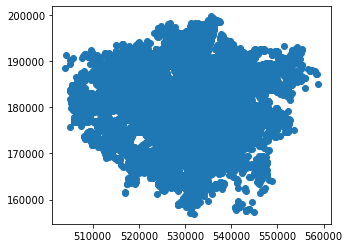

In [13]:
#check the geodataframe with a quick plot
gdf.plot()

### Quantify Airbnb listings

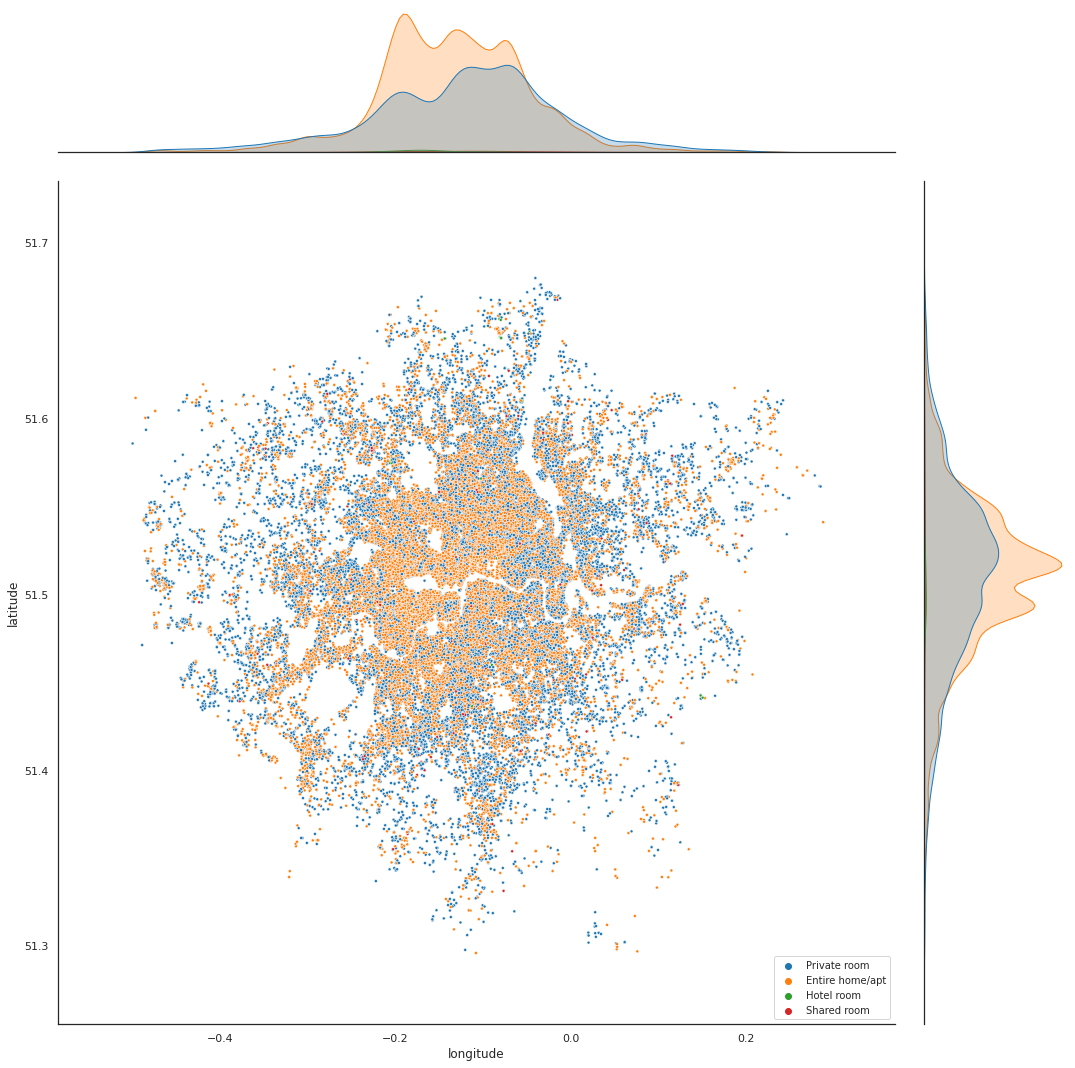

In [14]:
# create a joint plot to visualise the airbnb listings

sns.set(style="white")
g = sns.jointplot(data=gdf, x='longitude', y='latitude', marker=".",
                  hue='room_type', height=15 ,palette="tab10")
g.ax_joint.legend(loc='lower right', prop={'size': 10});


Visualise the Airbnb listings across London to get a first impression of the amount of listings in the city.
It would also be interesting to separate and plot a comparison between active and inactive Listings across London 

In order to filter out the active listings , this analysis will consider the last review date as indicator. 
Any review in the past year from the date the data was compiled (2021-10-10) will deem the listing active

In [15]:
gdf.sample(4, random_state=42)

name  latitude  \
id                                                                      
42409608            Cosy two bedroom home full of character  51.43951   
39318693      Frills-free yet Clean and Comfortable Bedroom  51.51699   
29555250  Unmissable Luxurious Mews House in Central London  51.49980   
19248360           Wonderful Private room+tea/coffee&sweets  51.53640   

          longitude                        property_type        room_type  \
id                                                                          
42409608   -0.19965                   Entire rental unit  Entire home/apt   
39318693   -0.06882  Private room in condominium (condo)     Private room   
29555250   -0.14976              Entire residential home  Entire home/apt   
19248360    0.01036          Private room in rental unit     Private room   

            price  availability_365  number_of_reviews_l30d first_review  \
id                                                                         
42409608  $100.00                 0                       0          NaN   
39318693   $17.00                 0                       0   2019-10-25   
29555250  $625.00               200                       0   2019-01-11   
19248360   $25.00                 0                       0   2017-06-25   

         last_review                       geometry  
id                                                   
42409608         NaN  POINT (525228.295 172705.369)  
39318693  2019-10-27  POINT (534093.520 181552.877)  
29555250  2018-12-19  POINT (528526.190 179496.193)  
19248360  2018-10-11  POINT (539527.700 183859.253)

In [16]:
# convert the values in the last review column to datetime type
gdf["last_review"]= pd.to_datetime(gdf["last_review"], infer_datetime_format=True)
#check
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67903 entries, 13913 to 52717191
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    67879 non-null  object        
 1   latitude                67903 non-null  float64       
 2   longitude               67903 non-null  float64       
 3   property_type           67903 non-null  object        
 4   room_type               67903 non-null  object        
 5   price                   67903 non-null  object        
 6   availability_365        67903 non-null  int64         
 7   number_of_reviews_l30d  67903 non-null  int64         
 8   first_review            48875 non-null  object        
 9   last_review             48875 non-null  datetime64[ns]
 10  geometry                67903 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(5)
memory usage: 6.2+ MB


In [17]:
# first remove the columns with no info for "last review" 
active_gdf = gdf.drop(gdf[gdf.last_review.isna()].index.values, axis=0)

# Filter for active listings
active_gdf = gdf.loc[gdf["last_review"] >= '2020-10-10']

# Display
active_gdf.sample(4, random_state=42)

name  latitude  \
id                                                                      
7019406                Spacious Classy Portobello Apartment  51.52359   
51033334      Superb 1 Bed Flat - Brick Lane (Free Parking)  51.52397   
47173303                    Beautiful room in Little Venice  51.52274   
26120791  Clean and Spacious Balcony Room - 15m to Hyde ...  51.53076   

          longitude                        property_type        room_type  \
id                                                                          
7019406    -0.20824                   Entire rental unit  Entire home/apt   
51033334   -0.06481           Entire condominium (condo)  Entire home/apt   
47173303   -0.19467  Private room in condominium (condo)     Private room   
26120791   -0.18641          Private room in rental unit     Private room   

            price  availability_365  number_of_reviews_l30d first_review  \
id                                                                         
7019406   $170.00               365                       0   2018-08-06   
51033334  $110.00                 0                       1   2021-07-26   
47173303   $40.00                11                       0   2020-12-27   
26120791   $50.00               115                       0   2018-07-16   

         last_review                       geometry  
id                                                   
7019406   2021-06-29  POINT (524402.487 182040.773)  
51033334  2021-10-04  POINT (534351.206 182336.422)  
47173303  2021-05-25  POINT (525346.187 181969.387)  
26120791  2021-07-24  POINT (525897.098 182875.417)

In [18]:
print(f"There are {active_gdf.shape[0]} active listings and {gdf.shape[0]} total listings")
print(f"The active listings are  {active_gdf.shape[0] *100 / gdf.shape[0]:,.2f}% of the total listings.")

There are 13577 active listings and 67903 total listings
The active listings are  19.99% of the total listings.


### Comparison map 

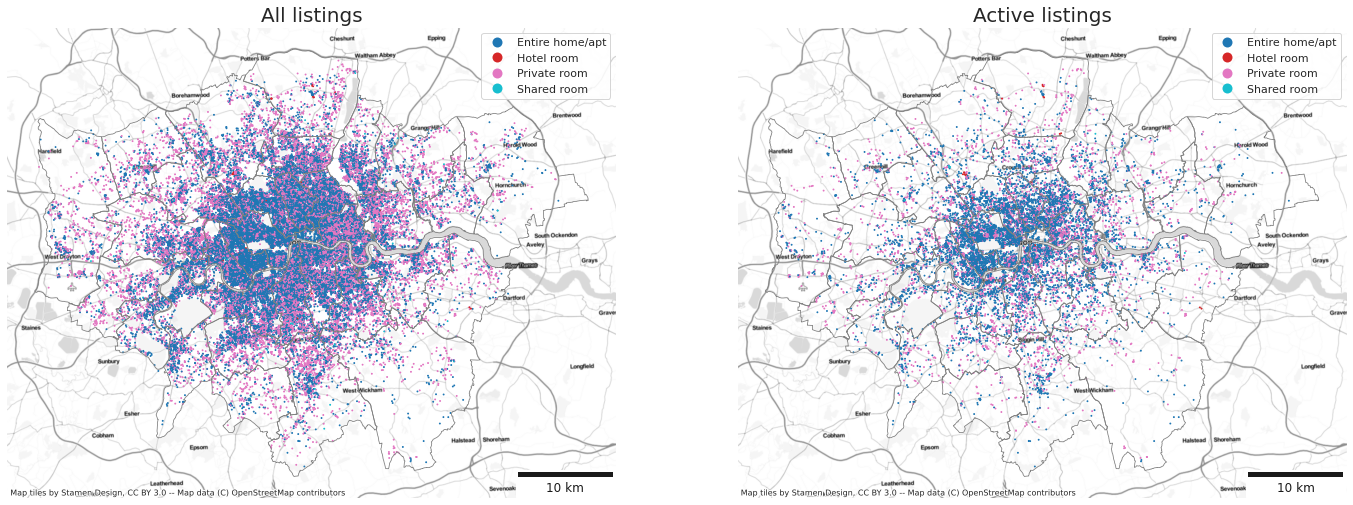

In [21]:
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

#create a base axis for the plot
fig, axes = plt.subplots(1,2, figsize = (24,16))

plt1 = 'All listings'
plt2 = 'Active listings'


# Scalebar position and layout
scale1 = ScaleBar(dx=1,
    location='lower right', 
    label_loc='left', scale_loc='bottom')
scale2 = ScaleBar(dx=1,
    location='lower right', 
    label_loc='left', scale_loc='bottom')


#plot 1

#plot the London outline 
boros.boundary.plot(ax=axes[0], edgecolor = "grey", linewidth=0.8)

#plot the airbnb listings
gdf.plot(ax = axes[0], cmap= "tab10", column="room_type", markersize = 0.8, legend=True)

#add basemap
ctx.add_basemap(ax= axes[0], crs= boros.crs,
               source = ctx.providers.Stamen.TonerLite)

#add scalebar 
axes[0].add_artist(scale1)


#plot 2

#plot the London outline 
boros.boundary.plot(ax=axes[1], edgecolor = "grey", linewidth=0.8)

#plot the active airbnb listings
active_gdf.plot(ax = axes[1], cmap= "tab10", column="room_type", markersize = 0.8, legend=True)

#add basemap
ctx.add_basemap(ax= axes[1], crs= boros.crs,
               source = ctx.providers.Stamen.TonerLite)

#add scalebar
axes[1].add_artist(scale2)

#set the axis off
for ax in axes:
    ax.axis('off')

#add titles 
# fig.suptitle('Airbnb Listings London (2021)', y=0.8,ha='center', size=24)
axes[0].set_title(plt1.capitalize(), size=20)
axes[1].set_title(plt2.capitalize(), size=20)

#export image
plt.savefig("Active_Airbnb_map_comparison_dots2.png", bbox_inches = 'tight')

The maps above show the magnitute of the Airbnb listings count across the area of London. Even the outer Boroughs seem to a substantial amount of listings. While the active listings are significantly less, the emerging pattern remains the same: high concentration of listing in the centre that spread outwards in smaller intensity. 

### Bar chart comparing Airbnb listings density across London Boroughs

In [22]:
# First join the Airbnb listings to the London Boroughs geometry
joined_boroughs = gpd.sjoin(gdf, boros, how='right', op='within').drop(columns=['latitude','longitude','index_left'])
joined_boroughs.head()

name  \
0   Spacious garden cabin, peaceful setting & homely   
0                                Greater London Flat   
0  3 bedroom flat with 4k TVs, Sky/Netflix & Parking   
0              Quite & Peaceful House in Chessington   
0    Beautiful 3 Bedroom House in Chessington Surrey   

                 property_type        room_type    price  availability_365  \
0        Private room in cabin     Private room   $55.00                25   
0  Private room in rental unit     Private room   $80.00               173   
0   Entire condominium (condo)  Entire home/apt  $131.00                75   
0      Entire residential home  Entire home/apt  $130.00               226   
0      Entire residential home  Entire home/apt  $149.00               353   

   number_of_reviews_l30d first_review last_review                  NAME  \
0                       2   2019-10-05  2021-10-04  Kingston upon Thames   
0                       0          NaN         NaT  Kingston upon Thames   
0                       2   2021-09-17  2021-09-27  Kingston upon Thames   
0                       0          NaN         NaT  Kingston upon Thames   
0                       1   2020-05-31  2021-09-18  Kingston upon Thames   

    GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  \
0  E09000021  3726.117         0.0         F   
0  E09000021  3726.117         0.0         F   
0  E09000021  3726.117         0.0         F   
0  E09000021  3726.117         0.0         F   
0  E09000021  3726.117         0.0         F   

                                            geometry  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....

In [23]:
#insert new columns:

# count of listings per Borough
joined_boroughs["listings_count"]=joined_boroughs.groupby(["GSS_CODE"])["price"].transform("count")

#calculate density of listings per Borough
joined_boroughs["listings_density"]=joined_boroughs["listings_count"]/joined_boroughs["HECTARES"]
joined_boroughs.head(2)


name  \
0  Spacious garden cabin, peaceful setting & homely   
0                               Greater London Flat   

                 property_type     room_type   price  availability_365  \
0        Private room in cabin  Private room  $55.00                25   
0  Private room in rental unit  Private room  $80.00               173   

   number_of_reviews_l30d first_review last_review                  NAME  \
0                       2   2019-10-05  2021-10-04  Kingston upon Thames   
0                       0          NaN         NaT  Kingston upon Thames   

    GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  \
0  E09000021  3726.117         0.0         F   
0  E09000021  3726.117         0.0         F   

                                            geometry  listings_count  \
0  MULTIPOLYGON (((516401.600 160201.800, 516407....             489   
0  MULTIPOLYGON (((516401.600 160201.800, 516407....             489   

   listings_density  
0          0.131236  
0          0.131236

In [24]:
# group by Borough and drop unnecessary columns, then sort by density so that the barchart can be ordered
list_boros = joined_boroughs.groupby(["GSS_CODE","NAME"]).sum().drop(columns=["availability_365","number_of_reviews_l30d","NONLD_AREA"]).reset_index().sort_values("listings_density", ascending=False)
list_boros

GSS_CODE                    NAME      HECTARES  listings_count  \
32  E09000033             Westminster  1.592552e+07        52258441   
19  E09000020  Kensington and Chelsea  5.929359e+06        22924944   
29  E09000030           Tower Hamlets  1.225245e+07        32251041   
11  E09000012                 Hackney  9.863583e+06        26811684   
18  E09000019               Islington  5.835688e+06        15429184   
6   E09000007                  Camden  1.006449e+07        21335161   
27  E09000028               Southwark  1.198929e+07        16064064   
12  E09000013  Hammersmith and Fulham  5.206266e+06         9211225   
21  E09000022                 Lambeth  1.034932e+07        14424804   
31  E09000032              Wandsworth  1.243626e+07        12467961   
13  E09000014                Haringey  5.594092e+06         3572100   
22  E09000023                Lewisham  6.795002e+06         3701776   
4   E09000005                   Brent  8.248799e+06         3640464   
24  E09000025                  Newham  6.195636e+06         2579236   
8   E09000009                  Ealing  8.748224e+06         2480625   
10  E09000011               Greenwich  7.414959e+06         2160900   
30  E09000031          Waltham Forest  4.889799e+06         1587600   
0   E09000001          City of London  1.121194e+05          126736   
23  E09000024                  Merton  4.142475e+06         1212201   
2   E09000003                  Barnet  1.304695e+07         2262016   
26  E09000027    Richmond upon Thames  6.140536e+06         1092025   
17  E09000018                Hounslow  5.596297e+06          978121   
7   E09000008                 Croydon  9.125160e+06         1113025   
25  E09000026               Redbridge  3.471198e+06          378225   
20  E09000021    Kingston upon Thames  1.822071e+06          239121   
1   E09000002    Barking and Dagenham  1.474174e+06          152100   
9   E09000010                 Enfield  4.693634e+06          326041   
14  E09000015                  Harrow  2.169922e+06          184900   
16  E09000017              Hillingdon  6.652786e+06          330625   
5   E09000006                 Bromley  8.152323e+06          294849   
28  E09000029                  Sutton  1.205792e+06           75625   
3   E09000004                  Bexley  1.748593e+06           73984   
15  E09000016                Havering  2.918662e+06           65025   

    listings_density  
32      23721.435494  
19      18512.058102  
29      14948.331890  
11      14075.098876  
18      10385.379197  
6        9791.568071  
27       5370.189948  
12       5369.696090  
21       5293.622612  
31       3540.000886  
13       1206.856999  
22       1048.155198  
4         842.062605  
24        668.575869  
8         446.603143  
10        428.393855  
30        409.091647  
0         402.410603  
23        322.182579  
2         260.756023  
26        185.841452  
17        172.857456  
7         128.681726  
25         67.010971  
20         64.174313  
1          40.238798  
9          39.664235  
14         36.640489  
16         28.575903  
5          19.638942  
28         17.247482  
3          11.508483  
15          5.681155

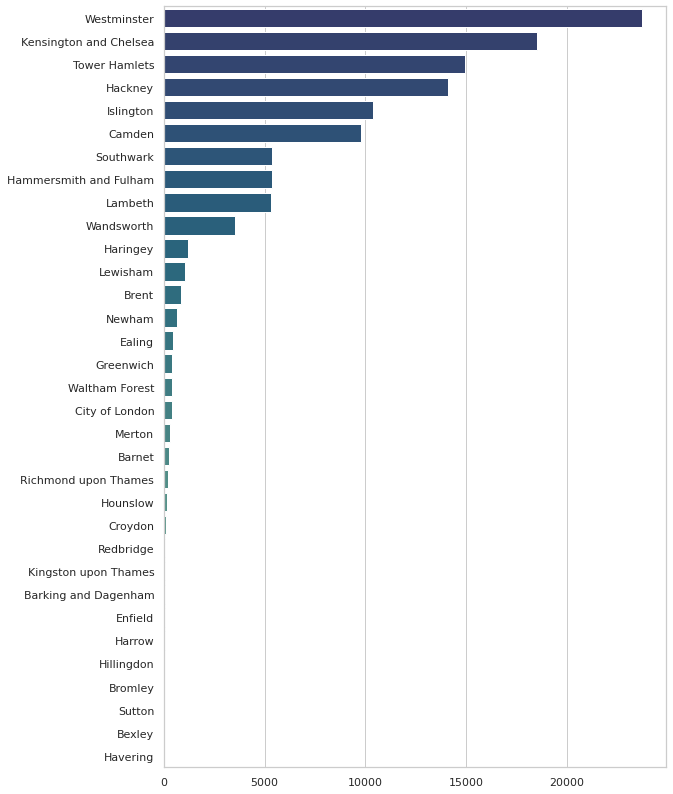

In [94]:
# create bar chart

sns.set(style="whitegrid")
#sns.set_theme(style='darkgrid')
plt.figure(figsize=(9, 14))

ax = sns.barplot( x="listings_density",
                  y="NAME", 
                 #hue="room_type",
                  data=list_boros,
                  order = list_boros["NAME"],
                  palette="crest_r")

#plt.xlabel("Airbnb Listings Density per Borough (1/ha)", size=14)
plt.xlabel(None)
plt.ylabel(None)

plt.savefig("Barplot_Listings_Density_per_Borough.png", bbox_inches = 'tight')

# Spacial unit

The London Boroughs are relatively large spatial units that will not capture more fine-grained variation across the city's urban fabric. Therefore, the subsequent analysis will be based on smaller spatial units, the Greater London Wards.

"The ward profiles and ward atlas provide a range of demographic and related data for each ward in Greater London. They are designed to provide an overview of the population in these small areas by presenting a range of data on the population, diversity, households, life expectancy, housing, crime, benefits, land use, deprivation, and employment" (source:https://data.london.gov.uk/dataset/ward-profiles-and-atlas)

Following data sets will be used:
* London Wards geopackage
* London Wards csv file

## London Wards (geometry)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

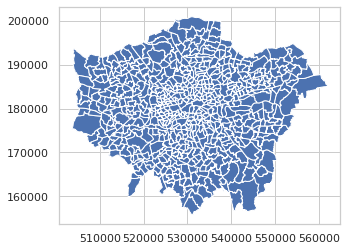

In [26]:
# load the Wards geopackage
wards_geo = gpd.read_file('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/geo/london_wards.gpkg?raw=true')
wards_geo.plot()

In [27]:
#make sure the crs is in British National Grid
wards_geo = wards_geo.to_crs('epsg:27700')

In [28]:
#check there are no NA values
wards_geo[wards_geo.isna().any(axis=1)]

Empty GeoDataFrame
Columns: [NAME, GSS_CODE, HECTARES, NONLD_AREA, LB_GSS_CD, BOROUGH, POLY_ID, geometry]
Index: []

The boundary highlighting the inner/outer London will be useful for subsequent plots. 
Using the statistical [definition](https://en.wikipedia.org/wiki/Inner_London), let's create this boundary.

In [29]:
# list the inner London boroughs

in_ldn = [
    "City of London",
    "Camden",
    "Newham",
    "Hackney",
    "Hammersmith and Fulham",
    "Islington",
    "Kensington and Chelsea",
    "Lambeth",
    "Lewisham",
    "Southwark",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
    "Haringey"
]

# and filter out the corresponding Wards
fltr = wards_geo["BOROUGH"].isin(in_ldn)
boros_il = wards_geo[fltr]

<AxesSubplot:>

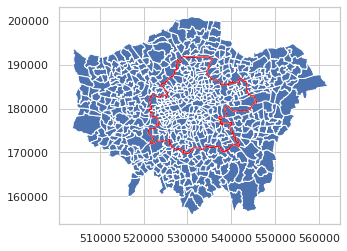

In [30]:
# plot the boundary of Inner London 
ax = wards_geo.plot()
gpd.GeoSeries(boros_il.unary_union).plot(ax=ax, edgecolor="red", facecolor="none")

## London Ward Profiles (data)

In [31]:
# Load in the Ward profiles
ward_profiles = pd.read_csv('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/raw/ward-profiles-excel-version.csv?raw=true',encoding= 'latin-1')
ward_profiles.tail(3)

Ward name Old code   New code  Population - 2015  \
657  Westminster     00BK  E09000033           230550.0   
658       London        H  E12000007          8632850.0   
659      England      921  E92000001         54613400.0   

     Children aged 0-15 - 2015  Working-age (16-64) - 2015  \
657                    33900.0                    170350.0   
658                  1726900.0                   5923600.0   
659                 10335450.0                  34540350.0   

     Older people aged 65+ - 2015  % All Children aged 0-15 - 2015  \
657                       26300.0                             14.7   
658                      982400.0                             20.0   
659                     9737650.0                             18.9   

     % All Working-age (16-64) - 2015  % All Older people aged 65+ - 2015  \
657                              73.9                                11.4   
658                              68.6                                11.4   
659                              63.2                                17.8   

     ...  A-Level Average Point Score Per Student - 2013/14  \
657  ...                                              680.5   
658  ...                                              689.9   
659  ...                                              696.3   

     A-Level Average Point Score Per Entry; 2013/14  Crime rate - 2014/15  \
657                                           210.2                 238.3   
658                                           211.4                  83.3   
659                                           211.5                  66.9   

     Violence against the person rate - 2014/15  \
657                                        39.5   
658                                        23.4   
659                                        13.4   

     Deliberate Fires per 1,000 population - 2014  \
657                                           0.2   
658                                           0.5   
659                                           NaN   

     % area that is open space - 2014  Cars per household - 2011  \
657                              28.6                        0.5   
658                              39.1                        0.8   
659                               NaN                        1.1   

     Average Public Transport Accessibility score - 2014  \
657                                                6.5     
658                                                3.8     
659                                                NaN     

     % travel by bicycle to work - 2011  Turnout at Mayoral election - 2012  
657                                 4.8                                37.7  
658                                 4.0                                34.2  
659                                 2.9                                 NaN  

[3 rows x 67 columns]

For the purposes of this analysis, just a small subset of variables will be used for the classification of the London wards. 

Using the already normalised measures available, following variables are selected:
* Median Age
* Population Density
* Percentage of BAME population
* Median Household income (estimate)
* Percentage of Flats,maisonettes or apartments
* Percentage of population with higher education 
* Average public Transport Accessiblity score

The selection, whilst not exhaustive , aims to capture geodeographic, social and economic characteristics of the subregions.

In [32]:
# store variables of interest in a list
keep_ward=["Ward name",
           "New code",
           "Median Age - 2013", 
           "Population density (persons per sq km) - 2013",
           "% BAME - 2011",
           "Median Household income estimate (2012/13)",
           "% Flat, maisonette or apartment - 2011",
           "% with Level 4 qualifications and above - 2011",
           "Average Public Transport Accessibility score - 2014" ]
# subset the dataframe
ward_data=ward_profiles[keep_ward]
# tidy up the column names
ward_data = ward_data.rename(columns={'Area_name':'Borough',
                          "New code":'Ward code',
                          "Median Age - 2013": "Median Age",
                          "Population density (persons per sq km) - 2013":"Pop density",
                          "% BAME - 2011":"BAME perc",
                          "Median Household income estimate (2012/13)":"Median income",
                          "% Flat, maisonette or apartment - 2011": "Flat perc",
                          "% with Level 4 qualifications and above - 2011": "High educ perc",
                          "Average Public Transport Accessibility score - 2014": "Transport"})
ward_data.tail()

Ward name  Ward code  Median Age  Pop density  BAME perc  \
655  Waltham Forest  E09000031        33.0       6897.0       47.8   
656      Wandsworth  E09000032        32.0       8853.9       28.6   
657     Westminster  E09000033        34.0      10285.8       38.3   
658          London  E12000007        33.0       5292.6       40.2   
659         England  E92000001        39.0        413.5       14.6   

     Median income  Flat perc  High educ perc  Transport  
655        39460.0       41.2            30.0        3.6  
656        66220.0       65.9            53.6        4.3  
657        80760.0       89.2            50.3        6.5  
658        51770.0       52.2            37.7        3.8  
659        30763.3       21.6            27.2        NaN

The last two entries are not wards but seem to be a London and England wide summary. These rows will be removed

In [33]:
ward_data.drop(index=[658,659], inplace=True)
ward_data.tail()

Ward name  Ward code  Median Age  Pop density  BAME perc  \
653          Sutton  E09000029        38.0       4480.3       21.4   
654   Tower Hamlets  E09000030        29.0      12564.7       54.8   
655  Waltham Forest  E09000031        33.0       6897.0       47.8   
656      Wandsworth  E09000032        32.0       8853.9       28.6   
657     Westminster  E09000033        34.0      10285.8       38.3   

     Median income  Flat perc  High educ perc  Transport  
653        49170.0       35.4            30.1        2.9  
654        45720.0       85.9            41.0        5.0  
655        39460.0       41.2            30.0        3.6  
656        66220.0       65.9            53.6        4.3  
657        80760.0       89.2            50.3        6.5

In [34]:
# check for other NA values
ward_data[ward_data.isna().any(axis=1)]

Empty DataFrame
Columns: [Ward name, Ward code, Median Age, Pop density, BAME perc, Median income, Flat perc, High educ perc, Transport]
Index: []

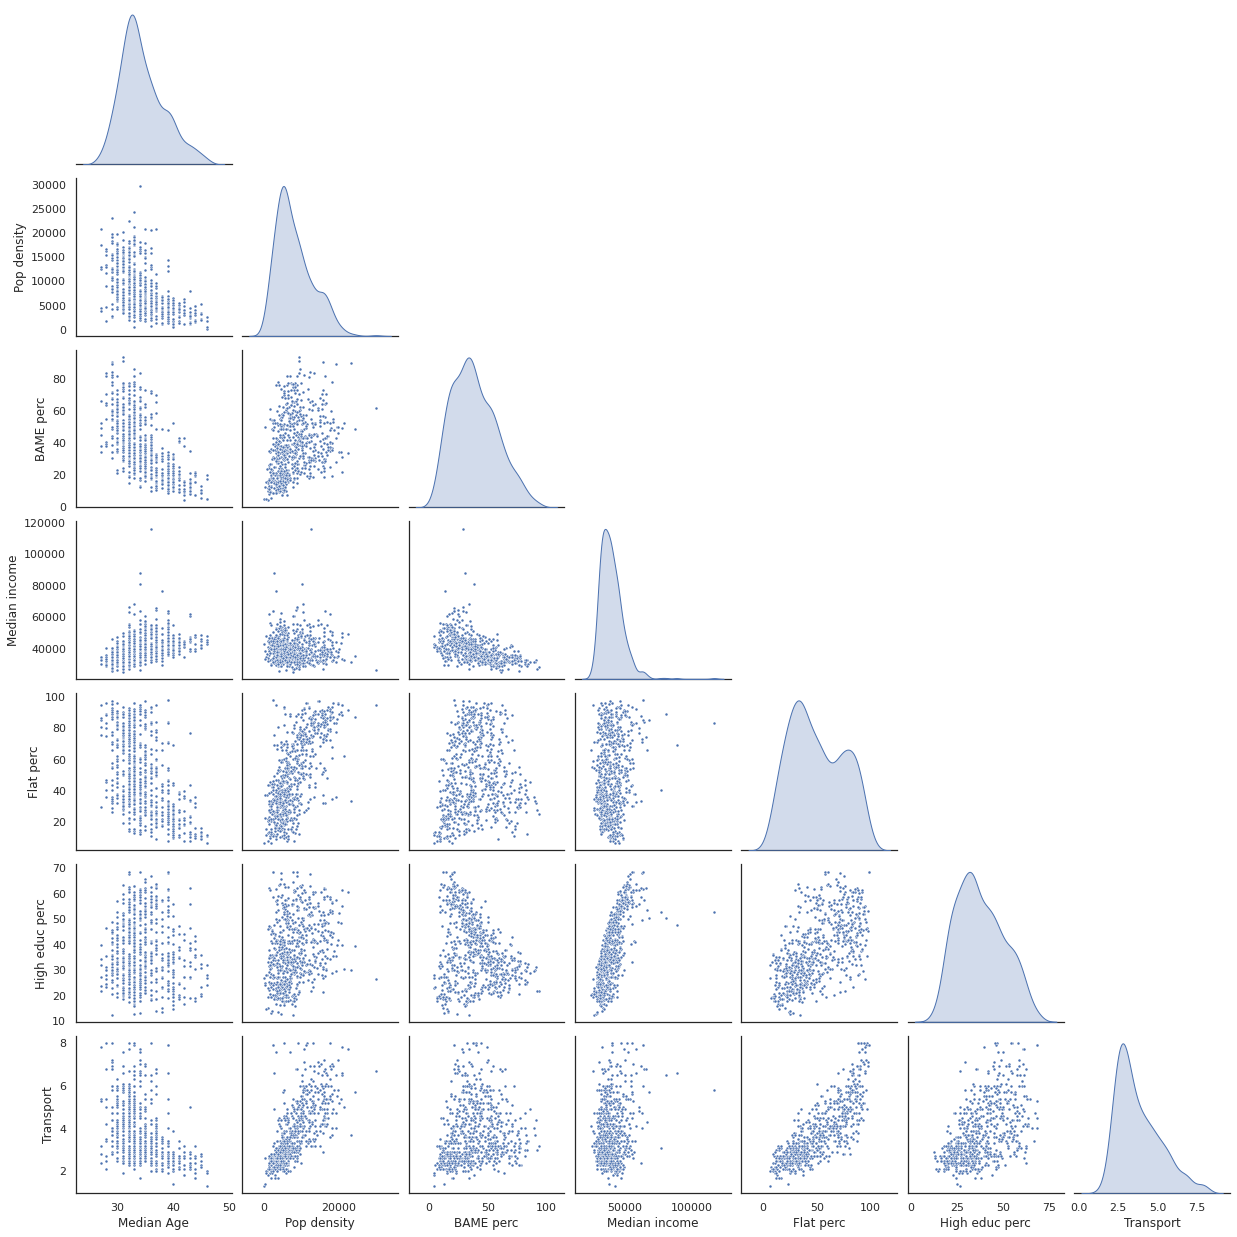

In [35]:
# using a quick plot to visualise the distribution of the variables
sns.set(style="white")
sns.pairplot(data=ward_data, markers=".", diag_kind='kde', corner=True)

### Airbnb Listings per Ward

After joining the airbnb listings to the wards geometry, the count and density of listings per Ward is calculated. This is then plotted on a map.
NOTE: Since the currently active listings number is substantially small (most possible due to the ongoing Covid 19 pandemic), all listings will be used

In [36]:
# Join the airbnb listings to the wards geometry with a spatial join 
joined_wards = gpd.sjoin(gdf, wards_geo, how='right', op='within').drop(columns=['latitude','longitude','index_left'])
joined_wards.head()

name  \
0   Spacious garden cabin, peaceful setting & homely   
0                                Greater London Flat   
0  3 bedroom flat with 4k TVs, Sky/Netflix & Parking   
0              Quite & Peaceful House in Chessington   
0    Beautiful 3 Bedroom House in Chessington Surrey   

                 property_type        room_type    price  availability_365  \
0        Private room in cabin     Private room   $55.00                25   
0  Private room in rental unit     Private room   $80.00               173   
0   Entire condominium (condo)  Entire home/apt  $131.00                75   
0      Entire residential home  Entire home/apt  $130.00               226   
0      Entire residential home  Entire home/apt  $149.00               353   

   number_of_reviews_l30d first_review last_review               NAME  \
0                       2   2019-10-05  2021-10-04  Chessington South   
0                       0          NaN         NaT  Chessington South   
0                       2   2021-09-17  2021-09-27  Chessington South   
0                       0          NaN         NaT  Chessington South   
0                       1   2020-05-31  2021-09-18  Chessington South   

    GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD               BOROUGH  POLY_ID  \
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   

                                            geometry  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
0  POLYGON ((516401.600 160201.800, 516407.300 16...

In [37]:
#insert new columns

# count of listings per ward
joined_wards["listings_count"]=joined_wards.groupby(["GSS_CODE"])["price"].transform("count")

In [38]:
#calculate density of listings per ward

joined_wards["listings_density"]=joined_wards["listings_count"]/joined_wards["HECTARES"]
joined_wards.head(2)


name  \
0  Spacious garden cabin, peaceful setting & homely   
0                               Greater London Flat   

                 property_type     room_type   price  availability_365  \
0        Private room in cabin  Private room  $55.00                25   
0  Private room in rental unit  Private room  $80.00               173   

   number_of_reviews_l30d first_review last_review               NAME  \
0                       2   2019-10-05  2021-10-04  Chessington South   
0                       0          NaN         NaT  Chessington South   

    GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD               BOROUGH  POLY_ID  \
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   
0  E05000405   755.173         0.0  E09000021  Kingston upon Thames    50840   

                                            geometry  listings_count  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...              15   
0  POLYGON ((516401.600 160201.800, 516407.300 16...              15   

   listings_density  
0          0.019863  
0          0.019863

Note:
It is possible that some wards do not have any listings. To avoid problems in the analysis that follows, the 0 in the listings_density column will be replaced by 0.0001 

In [39]:
# change the 0 values to 0.0001 in the listings_density columns so that log transformation will work
# no_listings = joined_wards.index[joined_wards['listings_count']==0].tolist()

for x in joined_wards.loc[joined_wards['listings_count']==0].index:
    joined_wards.at[x,"listings_density"]=0.0001

# check it worked
joined_wards.loc[joined_wards["listings_density"]==0]

Empty GeoDataFrame
Columns: [name, property_type, room_type, price, availability_365, number_of_reviews_l30d, first_review, last_review, NAME, GSS_CODE, HECTARES, NONLD_AREA, LB_GSS_CD, BOROUGH, POLY_ID, geometry, listings_count, listings_density]
Index: []

<AxesSubplot:ylabel='Frequency'>

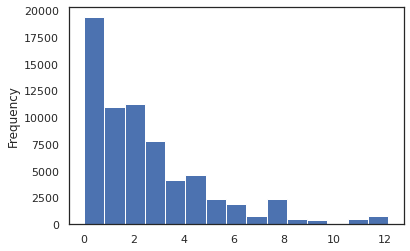

In [40]:
# plot histogram of the listings distribution 
joined_wards['listings_density'].plot.hist(bins=15) 

The listings density is heavily skewed. Let's check if a log transformation will produce a distribution closer to the normal distribution 

In [41]:
# add a column taking the log 
joined_wards["ln_listings_density"]= np.log(joined_wards["listings_density"])

<AxesSubplot:ylabel='Frequency'>

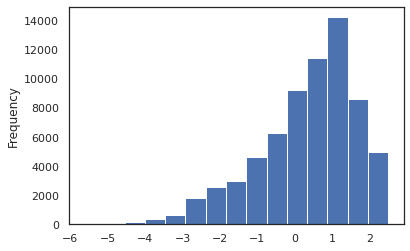

In [49]:
# plot histogram of the log transforme listings distribution 
joined_wards['ln_listings_density'].plot.hist(bins=15)

After log transforming the data the distribution seems slightly more normal

"\n#add a legendgram\n# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py\nlegendgram(f, ax,\n               joined_wards.ln_listings_density, q.bins, pal=palmpl.Viridis_4,\n               legend_size=(.3,.2), # legend size in fractions of the axis\n               loc = 'lower right', # mpl-style legend loc\n              # clip = (-7,3), # clip range of the histogram\n               frameon=False)\n"

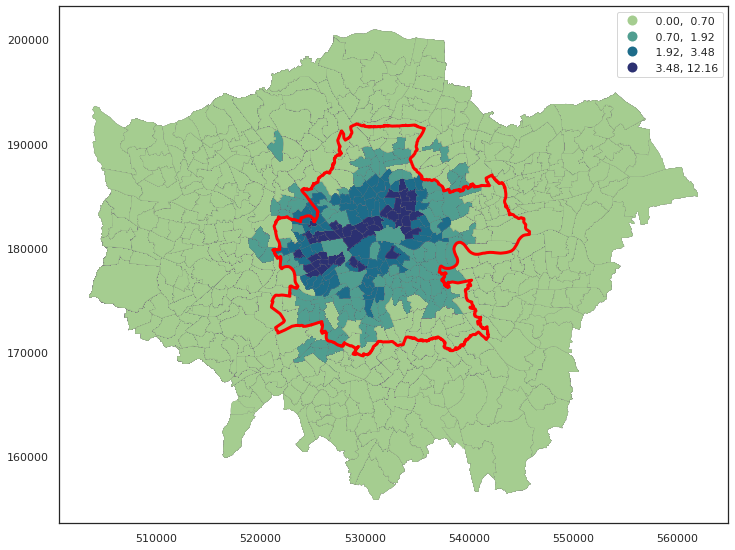

In [50]:
# plot the listings density on a London map

import pysal as ps
# https://github.com/pysal/mapclassify
import mapclassify as mc
# https://jiffyclub.github.io/palettable/
import palettable.matplotlib as palmpl
from legendgram import legendgram

f,ax = plt.subplots(figsize=(12,10))
joined_wards.plot(column='listings_density', scheme='quantiles', cmap='crest', edgecolor='grey',linewidth=0.1, k=4, ax=ax, legend=True)
q = mc.Quantiles(joined_wards.listings_density.values, k=4)

# add the inner london boundary 
gpd.GeoSeries(boros_il.unary_union).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=3)

"""
#add a legendgram
# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py
legendgram(f, ax,
               joined_wards.ln_listings_density, q.bins, pal=palmpl.Viridis_4,
               legend_size=(.3,.2), # legend size in fractions of the axis
               loc = 'lower right', # mpl-style legend loc
              # clip = (-7,3), # clip range of the histogram
               frameon=False)
"""

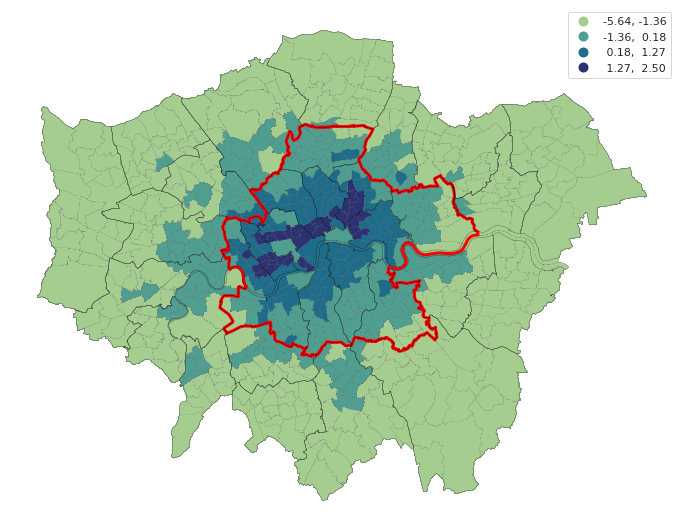

In [92]:
## plot the log transformed listings density on a London map

f,ax = plt.subplots(figsize=(12,10))

#f.suptitle('Airbnb Listings Density(log) London 2021', y=0.9,ha='center', size=20)

boros.boundary.plot(ax = ax, color = "black", alpha = 0.7, linewidth=0.3)
joined_wards.plot(column='ln_listings_density', scheme='naturalbreaks', cmap='crest',edgecolor='grey',linewidth=0.1, k=4, ax=ax, legend=True)
q = mc.Quantiles(joined_wards.ln_listings_density.values, k=4)

#set the axis off
ax.set_axis_off()

# add the inner london boundary 
gpd.GeoSeries(boros_il.unary_union).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=3)

# ax.add_artist(ScaleBar(1))

plt.savefig("Log Airbnb_density.png", bbox_inches = 'tight')


Now the census data will be added to the previous dataframe in order to create a complete dataframe that will be used in the clustering

In [52]:
# merge the census data with the previously joined dataframe
London_profiles = pd.merge( joined_wards, ward_data ,left_on = "GSS_CODE", right_on = "Ward code", how = "left")

In [53]:
# check it is still a geodataframe
type(London_profiles)

geopandas.geodataframe.GeoDataFrame

In [54]:
London_profiles.tail(5)

name                property_type  \
68248      The Victorian Townhouse, Old Street           Entire rental unit   
68249  Bright and nice dbl bedroom Clerkenwell  Private room in rental unit   
68250  Bright and nice dbl bedroom Clerkenwell  Private room in rental unit   
68251               single room in Clerkenwell  Private room in rental unit   
68252               single room in Clerkenwell  Private room in rental unit   

             room_type    price  availability_365  number_of_reviews_l30d  \
68248  Entire home/apt  $110.00               135                       2   
68249     Private room   $62.00                 0                       0   
68250     Private room   $62.00                 0                       0   
68251     Private room   $40.00               253                       0   
68252     Private room   $40.00               253                       0   

      first_review last_review            NAME   GSS_CODE  ...  \
68248   2017-03-20  2021-09-06  City of London  E09000001  ...   
68249   2017-11-19  2017-11-14  City of London  E09000001  ...   
68250   2017-11-19  2017-11-14  City of London  E09000001  ...   
68251   2016-10-24  2019-12-30  City of London  E09000001  ...   
68252   2016-10-24  2019-12-30  City of London  E09000001  ...   

       ln_listings_density       Ward name  Ward code Median Age  Pop density  \
68248             0.122539  City of London  E09000001       39.0       2538.1   
68249             0.122539  City of London  E09000001       39.0       2538.1   
68250             0.122539  City of London  E09000001       39.0       2538.1   
68251             0.122539  City of London  E09000001       39.0       2538.1   
68252             0.122539  City of London  E09000001       39.0       2538.1   

      BAME perc  Median income  Flat perc  High educ perc Transport  
68248      21.4        63620.0       98.0            68.4       7.9  
68249      21.4        63620.0       98.0            68.4       7.9  
68250      21.4        63620.0       98.0            68.4       7.9  
68251      21.4        63620.0       98.0            68.4       7.9  
68252      21.4        63620.0       98.0            68.4       7.9  

[5 rows x 28 columns]

In [55]:
#drop the dupicate entries for each ward
London_profiles.drop_duplicates(subset="GSS_CODE", inplace=True)
#drop the columns no longer needed
London_profiles.drop(columns=["Ward name", "Ward code","NONLD_AREA","POLY_ID","name","property_type","room_type","price","availability_365","number_of_reviews_l30d","first_review","last_review"], inplace=True)
London_profiles

NAME   GSS_CODE  HECTARES  LB_GSS_CD  \
0           Chessington South  E05000405   755.173  E09000021   
15     Tolworth and Hook Rise  E05000414   259.464  E09000021   
26                 Berrylands  E05000401   145.390  E09000021   
49                  Alexandra  E05000400   268.506  E09000021   
63                   Beverley  E05000402   187.821  E09000021   
...                       ...        ...       ...        ...   
67481               Whalebone  E05000042   155.399  E09000002   
67492               Eastbrook  E05000030   345.060  E09000002   
67503          Chadwell Heath  E05000029   338.422  E09000002   
67527                Parsloes  E05000037   124.384  E09000002   
67541          City of London  E09000001   314.943  E09000001   

                    BOROUGH  \
0      Kingston upon Thames   
15     Kingston upon Thames   
26     Kingston upon Thames   
49     Kingston upon Thames   
63     Kingston upon Thames   
...                     ...   
67481  Barking and Dagenham   
67492  Barking and Dagenham   
67503  Barking and Dagenham   
67527  Barking and Dagenham   
67541        City of London   

                                                geometry  listings_count  \
0      POLYGON ((516401.600 160201.800, 516407.300 16...              15   
15     POLYGON ((517829.600 165447.100, 517837.100 16...              11   
26     POLYGON ((518107.500 167303.400, 518114.300 16...              23   
49     POLYGON ((520480.000 166909.800, 520490.700 16...              14   
63     POLYGON ((522071.000 168144.900, 522063.900 16...              34   
...                                                  ...             ...   
67481  POLYGON ((549410.700 187450.700, 549391.200 18...              11   
67492  POLYGON ((549991.500 184928.500, 549988.900 18...              11   
67503  POLYGON ((547715.200 187914.200, 547712.500 18...              24   
67527  POLYGON ((547381.600 185753.600, 547377.500 18...              14   
67541  POLYGON ((531361.300 180691.000, 531313.200 18...             356   

       listings_density  ln_listings_density  Median Age  Pop density  \
0              0.019863            -3.918897        37.0       1375.0   
15             0.042395            -3.160723        36.0       3961.5   
26             0.158195            -1.843926        36.0       6466.7   
49             0.052140            -2.953816        39.0       3537.0   
63             0.181023            -1.709129        37.0       5447.4   
...                 ...                  ...         ...          ...   
67481          0.070786            -2.648101        34.0       6781.3   
67492          0.031879            -3.445823        36.0       3028.6   
67503          0.070917            -2.646240        34.0       2985.3   
67527          0.112555            -2.184316        33.0       8250.0   
67541          1.130363             0.122539        39.0       2538.1   

       BAME perc  Median income  Flat perc  High educ perc  Transport  
0           13.0        38310.0       20.9            25.3        2.4  
15          27.2        37840.0       22.0            30.0        2.3  
26          18.1        42330.0       54.7            48.4        2.8  
49          29.8        41390.0       12.0            32.7        2.2  
63          32.6        40700.0       30.4            41.7        2.8  
...          ...            ...        ...             ...        ...  
67481       44.0        37180.0       27.8            22.4        2.9  
67492       24.8        37400.0       18.4            18.5        2.3  
67503       37.9        33920.0       34.5            19.5        2.3  
67527       30.9        31860.0       12.6            16.0        2.7  
67541       21.4        63620.0       98.0            68.4        7.9  

[625 rows x 16 columns]

In [56]:
London_profiles.isna().sum()

NAME                   0
GSS_CODE               0
HECTARES               0
LB_GSS_CD              0
BOROUGH                0
geometry               0
listings_count         0
listings_density       0
ln_listings_density    0
Median Age             0
Pop density            0
BAME perc              0
Median income          0
Flat perc              0
High educ perc         0
Transport              0
dtype: int64

## data preparation for k-means clustering

In the attempt to better understand where and why listings are concentrating, this analysis employs a form of statistical clustering known as K-Means to group the London Wards based on the concentration of Airbnb listings and variables deriving from the previously loaded London Wards Profiles

In [57]:
# extract the column names 
cols_profiles=London_profiles.columns
print(cols_profiles)


Index(['NAME', 'GSS_CODE', 'HECTARES', 'LB_GSS_CD', 'BOROUGH', 'geometry',
       'listings_count', 'listings_density', 'ln_listings_density',
       'Median Age', 'Pop density', 'BAME perc', 'Median income', 'Flat perc',
       'High educ perc', 'Transport'],
      dtype='object')


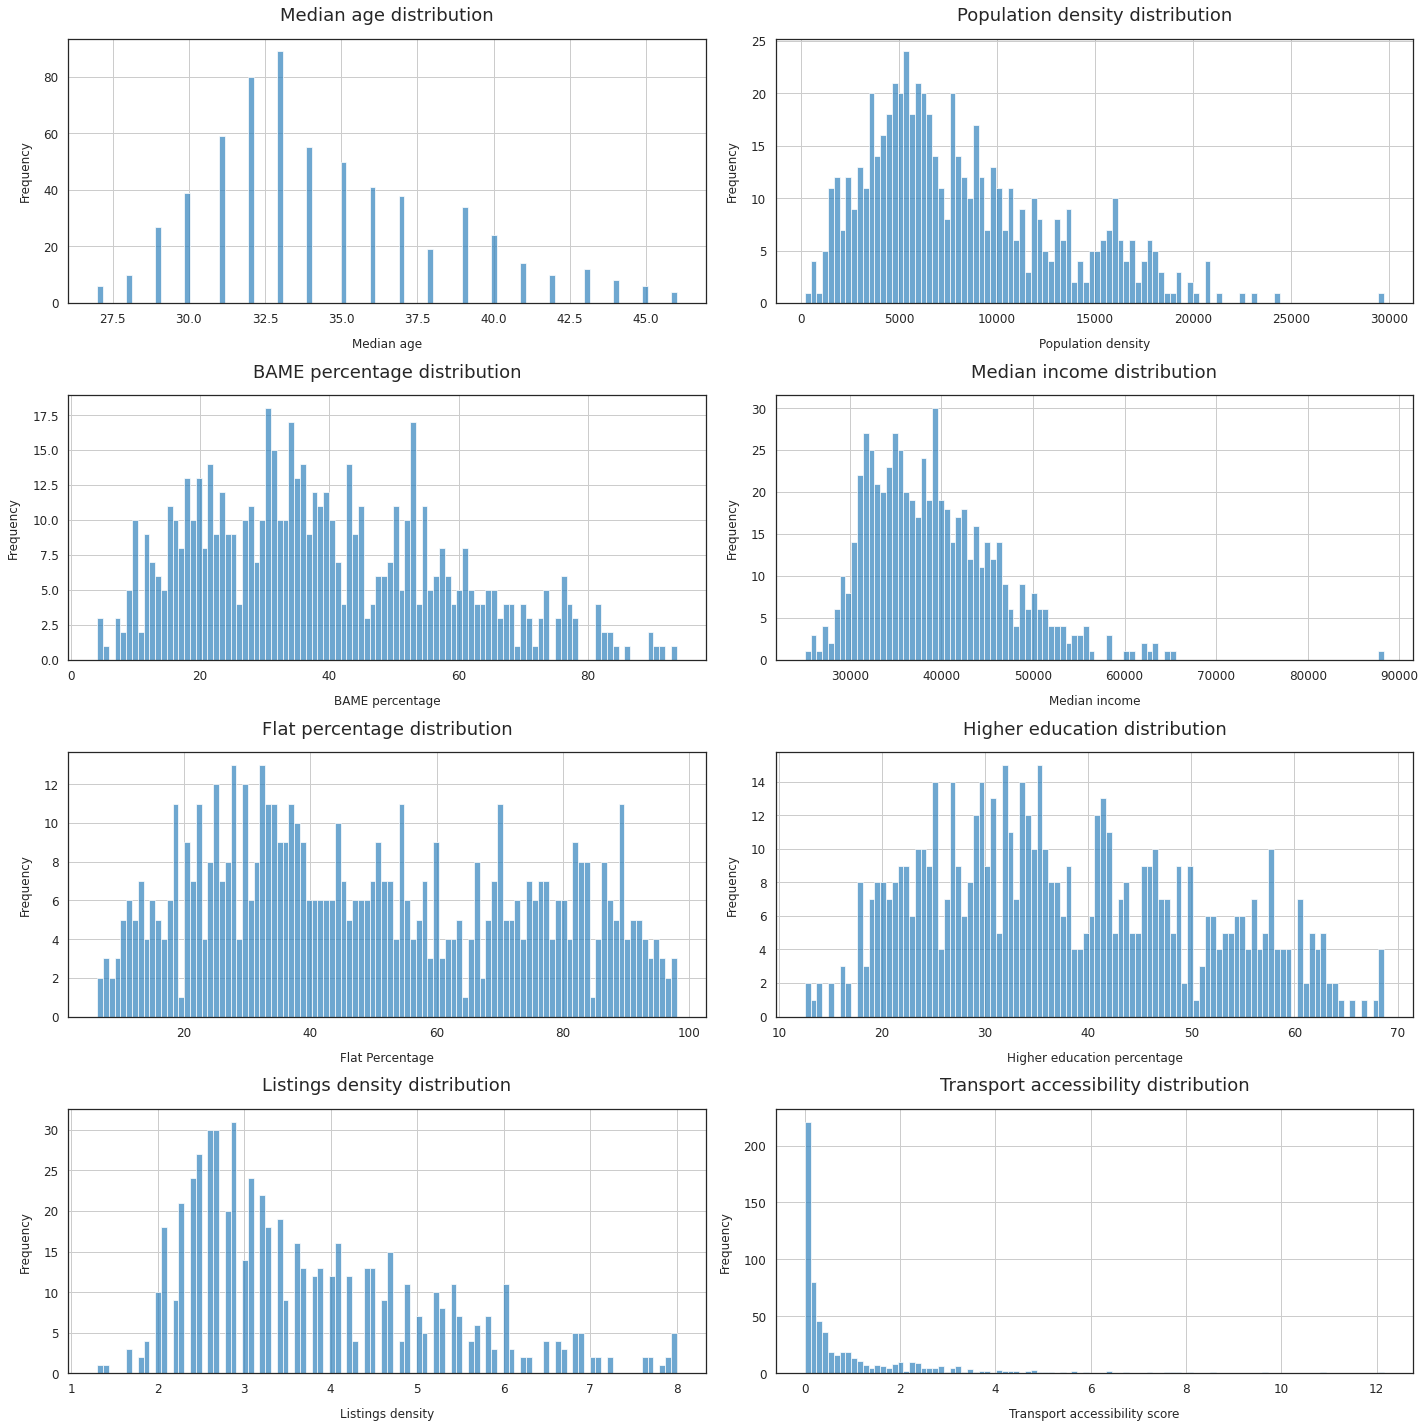

In [91]:
# code below from Philip Wilkinson : https://github.com/PhilipDW183/Convenience_store/blob/main/Convenience%20store%20exploration.ipynb

#set the columns for the analysis
columns = ['Median Age', 
           'Pop density', 
           'BAME perc',
           'Median income',
           'Flat perc', 
           'High educ perc', 
           'Transport',
           'listings_density']

#set the histogram titles
hist_titles = ["Median age distribution",
              "Population density distribution",
              "BAME percentage distribution",
              "Median income distribution",
              "Flat percentage distribution",
              "Higher education distribution",
              "Listings density distribution",
              "Transport accessibility distribution" ]

#set the acis labels
axis_labels = ["Median age", 
              "Population density",
              "BAME percentage",
              "Median income",
              "Flat Percentage",
              "Higher education percentage",
              "Listings density",
              "Transport accessibility score"]

#create a base axis for teh plots
fig, ax = plt.subplots(4,2, figsize = (20,20))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(columns):
    
    #create the histogram using the column
    London_profiles[col].hist(bins = 100, ax = axis[i],
                                       color = "#3182bd",
                                       alpha = 0.7)
    #add label information
    axis[i].set_title(hist_titles[i], fontsize = 18, pad = 18)
    axis[i].set_ylabel("Frequency", fontsize  =12, labelpad = 12)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 12, labelpad = 12)
    axis[i].tick_params(axis = "both", labelsize = 12)

#keep the layout tight
plt.tight_layout()

plt.savefig("Variables_distribution_hist.png", bbox_inches = 'tight')

The distributions above show that the the variables have different distributions (Population, education, listings, transport are heavily skewed for example) and they also have different range and units. The data needs to be standardised so that none of the variables dominates the clustering process. 


For comleteness lets, also plot the variation of these variables across the London Wards.

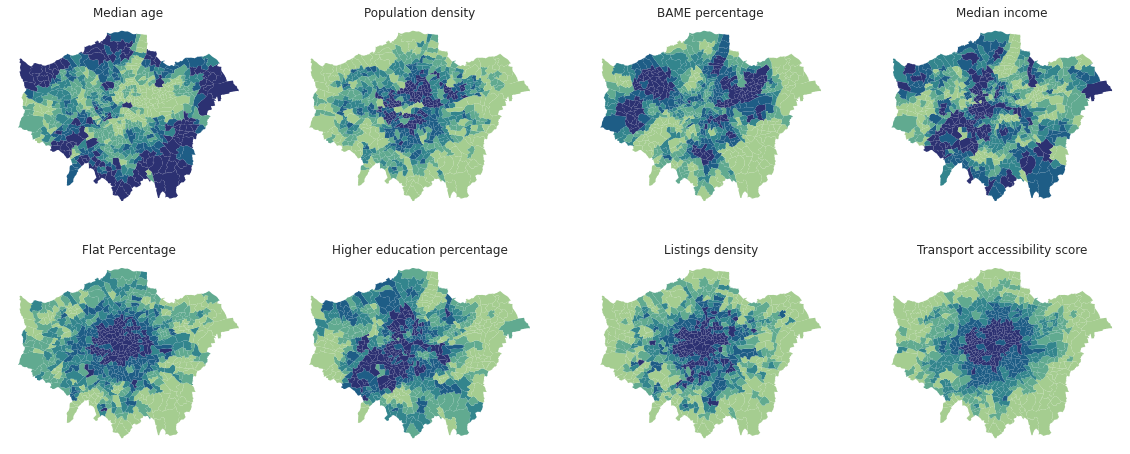

In [83]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(columns):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    London_profiles.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap="crest"
    )
    # Remove axis clutter
    ax.set_axis_off()
    
    # Set the axis title to the name of variable being plotted
    ax.set_title(axis_labels[i])


#export image
plt.savefig("Variables_maps.png", bbox_inches = 'tight')



# create a table listing the variables

| name | description | category | source |
| ----------- | ----------- | ----------- | ----------- |
| Median age |Median Age (2013)| demographic | London Wards Profiles |
| Population density | Population density (2013) | geodemographic | London Wards Profiles |
| BAME percentage | Percentage of BAME (2011) | demographic | London Wards Profiles |
| Median income | Median Household income estimate (2012/13) | economic | London Wards Profiles |
| Flat percentage | Percentage of Flat, maisonette or apartment (2011) | housing | London Wards Profiles |
| Higher Education percentage | Percentage with Level 4 qualifications and above (2011) | socialdemographic | London Wards Profiles |
| Transport | Average Public Transport Accessibility score (2014) | location/attactiveness | London Wards Profiles |
| Listings Density | Airbnb listings density per area (2021) | Airbnb | Inside Airbnb |

In [81]:
# create a dataframe with the variabels

clustA=London_profiles[columns]
clustA

Median Age  Pop density  BAME perc  Median income  Flat perc  \
0           37.00     1,375.00      13.00      38,310.00      20.90   
15          36.00     3,961.50      27.20      37,840.00      22.00   
26          36.00     6,466.70      18.10      42,330.00      54.70   
49          39.00     3,537.00      29.80      41,390.00      12.00   
63          37.00     5,447.40      32.60      40,700.00      30.40   
...           ...          ...        ...            ...        ...   
67481       34.00     6,781.30      44.00      37,180.00      27.80   
67492       36.00     3,028.60      24.80      37,400.00      18.40   
67503       34.00     2,985.30      37.90      33,920.00      34.50   
67527       33.00     8,250.00      30.90      31,860.00      12.60   
67541       39.00     2,538.10      21.40      63,620.00      98.00   

       High educ perc  Transport  listings_density  
0               25.30       2.40              0.02  
15              30.00       2.30              0.04  
26              48.40       2.80              0.16  
49              32.70       2.20              0.05  
63              41.70       2.80              0.18  
...               ...        ...               ...  
67481           22.40       2.90              0.07  
67492           18.50       2.30              0.03  
67503           19.50       2.30              0.07  
67527           16.00       2.70              0.11  
67541           68.40       7.90              1.13  

[625 rows x 8 columns]

#### Initialise the Scalers and Transformers

In [62]:
import sklearn
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [63]:
# rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer(method='box-cox')

In [64]:
# Rescale the columns 
for c in clustA.columns:
    clustA[c] = mms.fit_transform(clustA[c].values.reshape(-1,1))
clustA.head(10)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Median Age  Pop density  BAME perc  Median income  Flat perc  \
0          0.05        -0.92      -0.80          -0.58      -0.68   
15        -0.05        -0.74      -0.48          -0.60      -0.66   
26        -0.05        -0.57      -0.69          -0.45       0.06   
49         0.26        -0.77      -0.43          -0.48      -0.88   
63         0.05        -0.64      -0.36          -0.51      -0.47   
97        -0.26        -0.85      -0.30          -0.35      -0.22   
146        0.16        -0.69      -0.76          -0.62      -0.76   
148       -0.16        -0.58      -0.67          -0.43       0.12   
175        0.37        -0.65      -0.40          -0.47      -0.73   
186       -0.68        -0.49      -0.62          -0.37       0.39   

     High educ perc  Transport  listings_density  
0             -0.54      -0.67             -1.00  
15            -0.38      -0.70             -0.99  
26             0.28      -0.55             -0.97  
49            -0.28      -0.73             -0.99  
63             0.04      -0.55             -0.97  
97             0.14      -0.64             -0.98  
146           -0.63      -0.67             -1.00  
148            0.41      -0.40             -0.97  
175           -0.22      -0.58             -0.99  
186            0.27      -0.28             -0.95

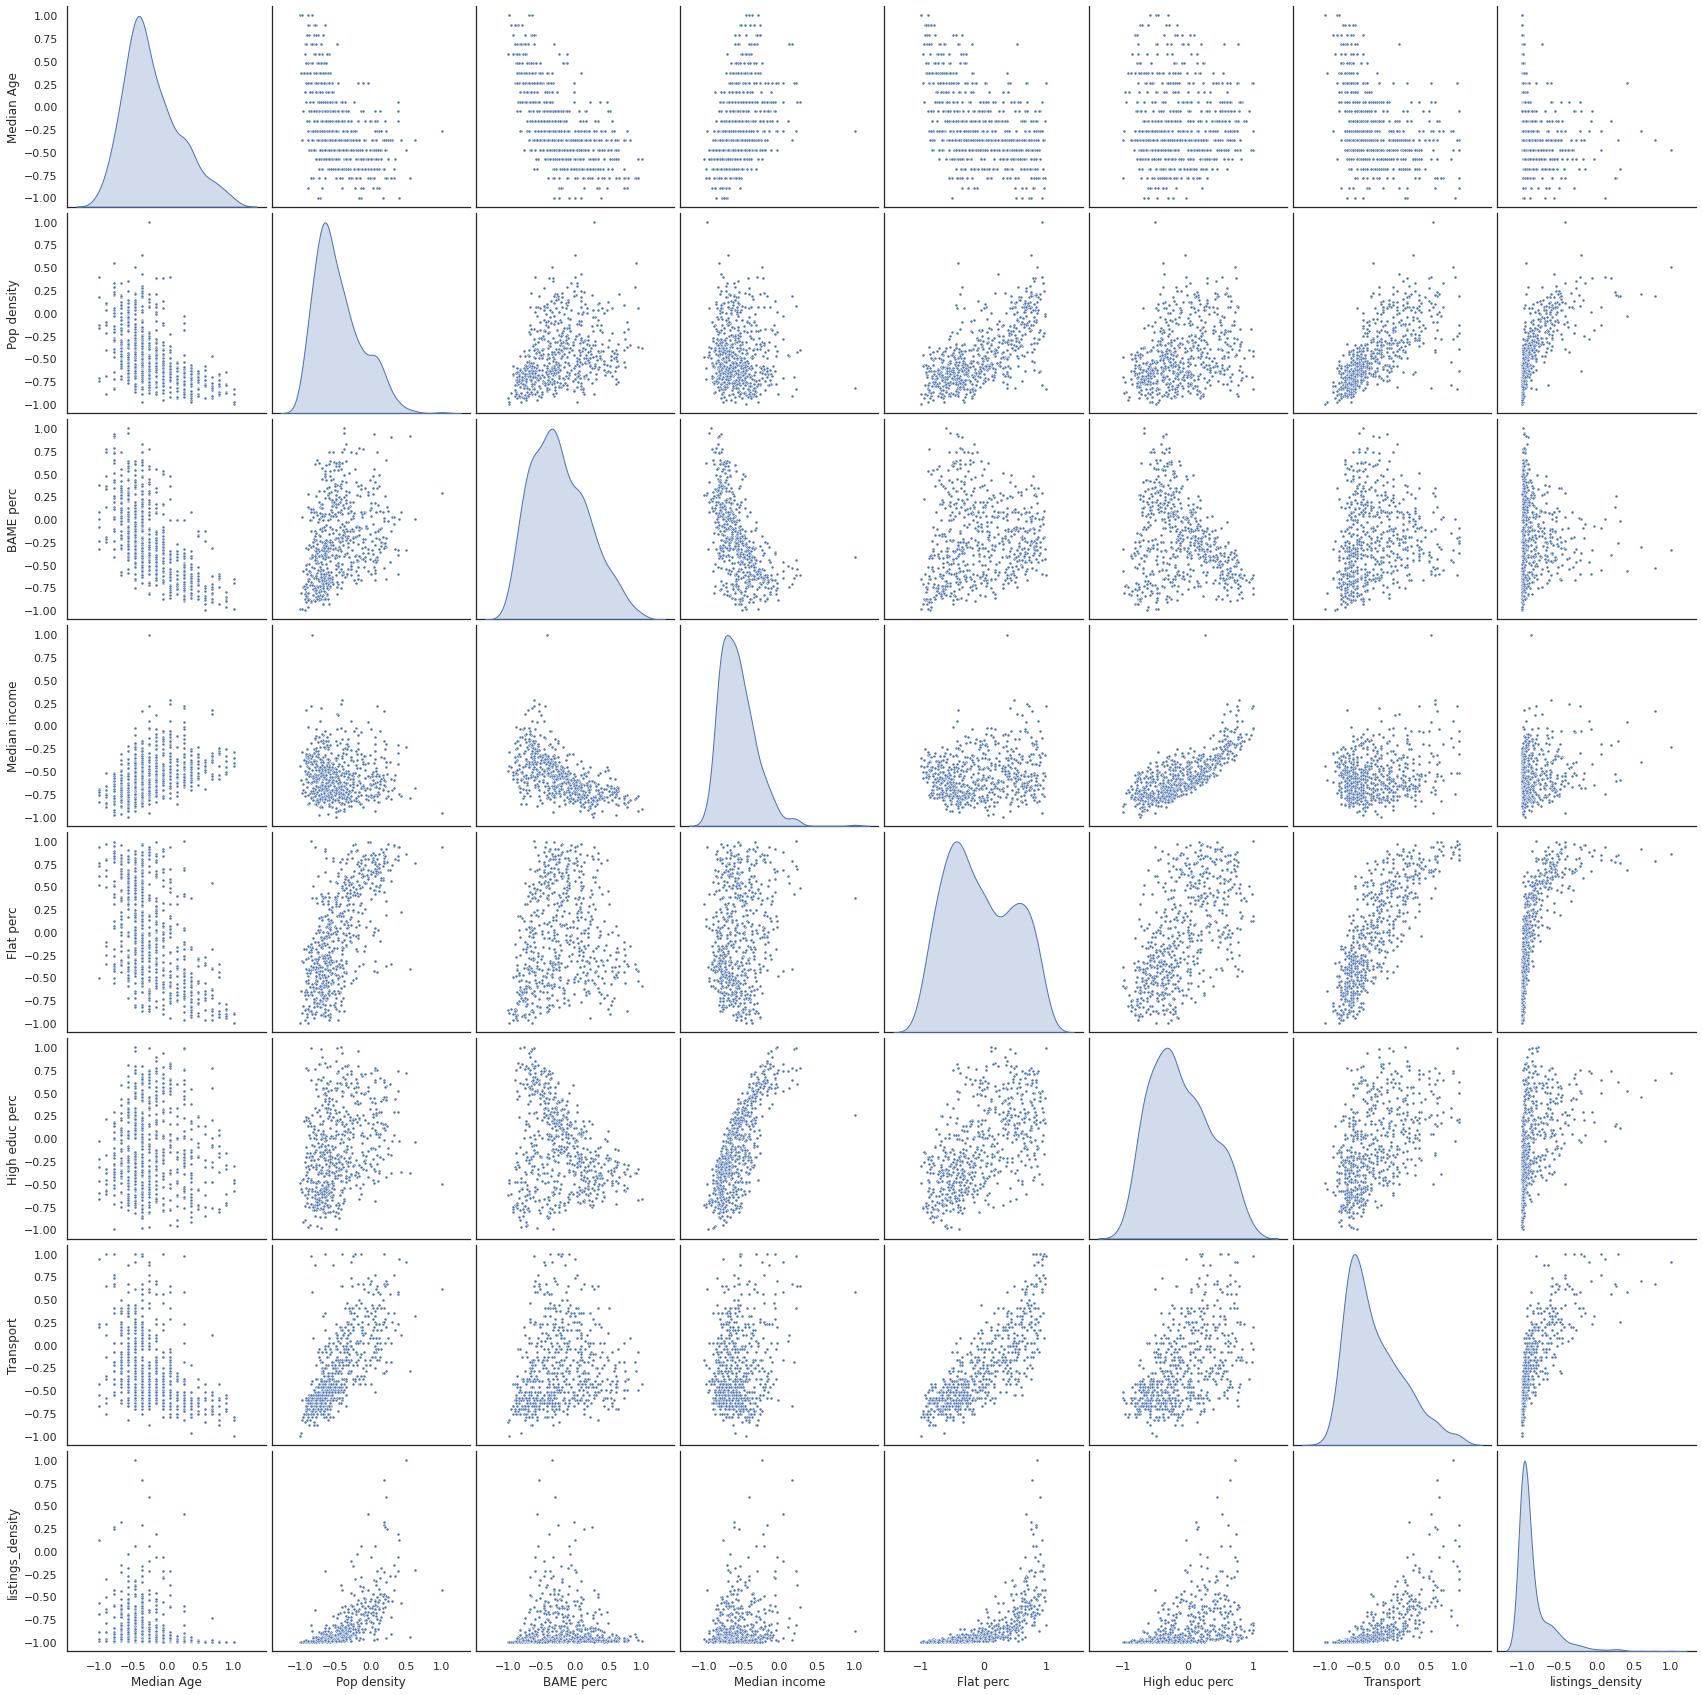

In [65]:
# quick plot to visualise the results
sns.set(style="white")
sns.pairplot(clustA, markers=".", height=3, diag_kind='kde');

In [66]:
clustA.describe()

Median Age  Pop density  BAME perc  Median income  Flat perc  \
count      625.00       625.00     625.00         625.00     625.00   
mean        -0.21        -0.45      -0.23          -0.55      -0.05   
std          0.42         0.33       0.42           0.24       0.54   
min         -1.00        -1.00      -1.00          -1.00      -1.00   
25%         -0.47        -0.69      -0.57          -0.73      -0.50   
50%         -0.26        -0.54      -0.29          -0.59      -0.13   
75%          0.05        -0.27       0.08          -0.42       0.42   
max          1.00         1.00       1.00           1.00       1.00   

       High educ perc  Transport  listings_density  
count          625.00     625.00            625.00  
mean            -0.10      -0.26             -0.84  
std              0.46       0.42              0.26  
min             -1.00      -1.00             -1.00  
25%             -0.47      -0.58             -0.99  
50%             -0.18      -0.37             -0.96  
75%              0.23      -0.01             -0.82  
max              1.00       1.00              1.00

In [67]:
#import the necessary libraries
from sklearn import metrics
from sklearn.cluster import KMeans

#create an empty list
list_SSE = []
#set the range of clusters to evaluate
min_k = 1
max_k = 11
range_k = range(min_k, max_k)

In [68]:
#iterate over the range
for i in range_k:
    #perform the clustering algorithm
    km = KMeans(n_clusters = i,
               init = "random",
               n_init = 10,
               max_iter = 300,
               tol = 1e-04, 
               random_state = 42)
    #fit this to the data
    km.fit(clustA[columns])
    #add the SEE score
    list_SSE.append(km.inertia_)   

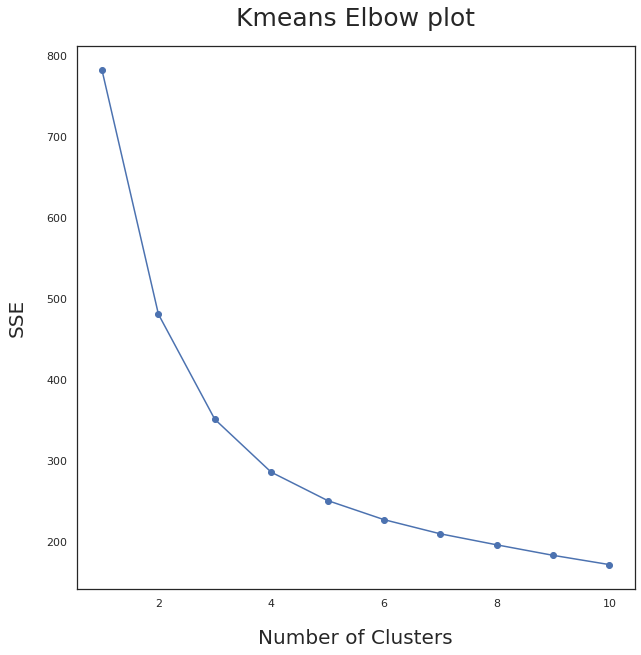

In [69]:
#create the base plots
fig, ax = plt.subplots(1,1, figsize = (10,10))

#add the data to the axis
ax.plot(range_k, list_SSE, marker = "o")

#add the necessary labels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax.set_ylabel("SSE", fontsize =20, labelpad = 20)
ax.set_title("Kmeans Elbow plot", fontsize = 25, pad = 20)

plt.show()



In [70]:
#for the silhouette score
import random

#create an empty list
silhouette = []

#iteratre over the number of clusters to evaluate
for i in range(2,11):
    
    #create an empty list to hold the averages
    average = []
    #perform the clustering algorithm several times for each number of clusters
    for x in range(1,10):
        #set the number of clusters
        k_cluster = i
        #generate a arandom seed number
        random_seed = random.randint(1,101)
        #apply the KMeans clustering algorithm
        kmeans_method = KMeans(n_clusters = k_cluster,
                              random_state = random_seed)
        kmeans_method.fit(clustA[columns])
        #extract the labels
        labels = kmeans_method.labels_
        #extract the silhouette score
        a = metrics.silhouette_score(clustA[columns], labels)
        #append the result
        average.append(a)
    #calculate the average silhouette score for each number of clusters 
    silhouette.append(sum(average)/len(average))



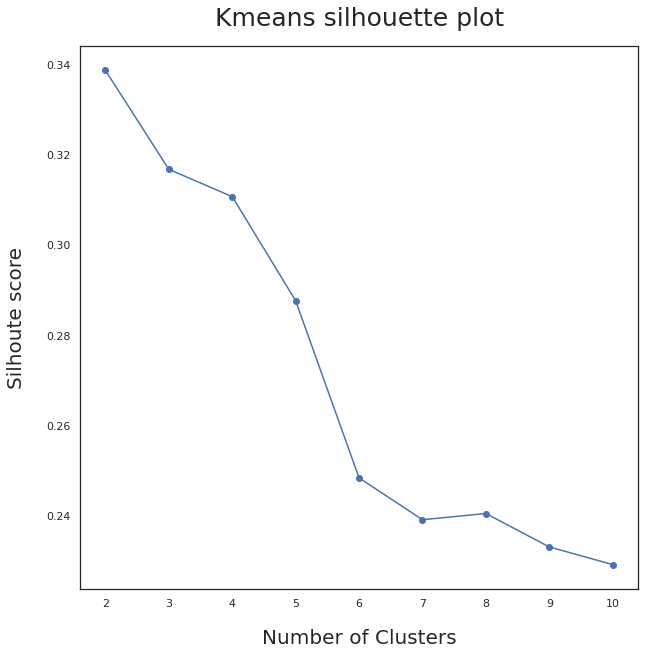

In [71]:
#create a base axis
fig, ax = plt.subplots(1,1, figsize = (10,10))

#plot the results
ax.plot(range(2,11), silhouette, marker = "o")

#add the lbels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax.set_ylabel("Silhoute score", fontsize =20, labelpad = 20)
ax.set_title("Kmeans silhouette plot", fontsize = 25, pad = 20)

plt.show()

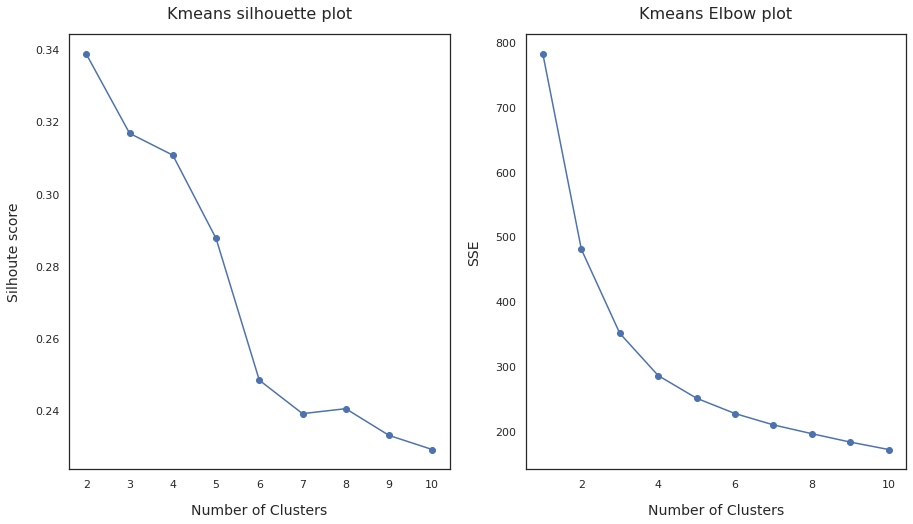

In [85]:
#combine both plots
fig, ax = plt.subplots(1,2, figsize = (15,8))

ax[0].plot(range(2,11), silhouette, marker = "o")
ax[0].set_xlabel("Number of Clusters", fontsize = 14, labelpad = 14)
ax[0].set_ylabel("Silhoute score", fontsize =14, labelpad = 14)
ax[0].set_title("Kmeans silhouette plot", fontsize = 16, pad = 16)

ax[1].plot(range_k, list_SSE, marker = "o")
ax[1].set_xlabel("Number of Clusters", fontsize = 14, labelpad = 14)
ax[1].set_ylabel("SSE", fontsize =14, labelpad = 14)
ax[1].set_title("Kmeans Elbow plot", fontsize = 16, pad = 16)

#export image
plt.savefig("Silhouette_elbow_plot.png", bbox_inches = 'tight')


The above plots indicate that after 2 the optimal number of clusters is 4

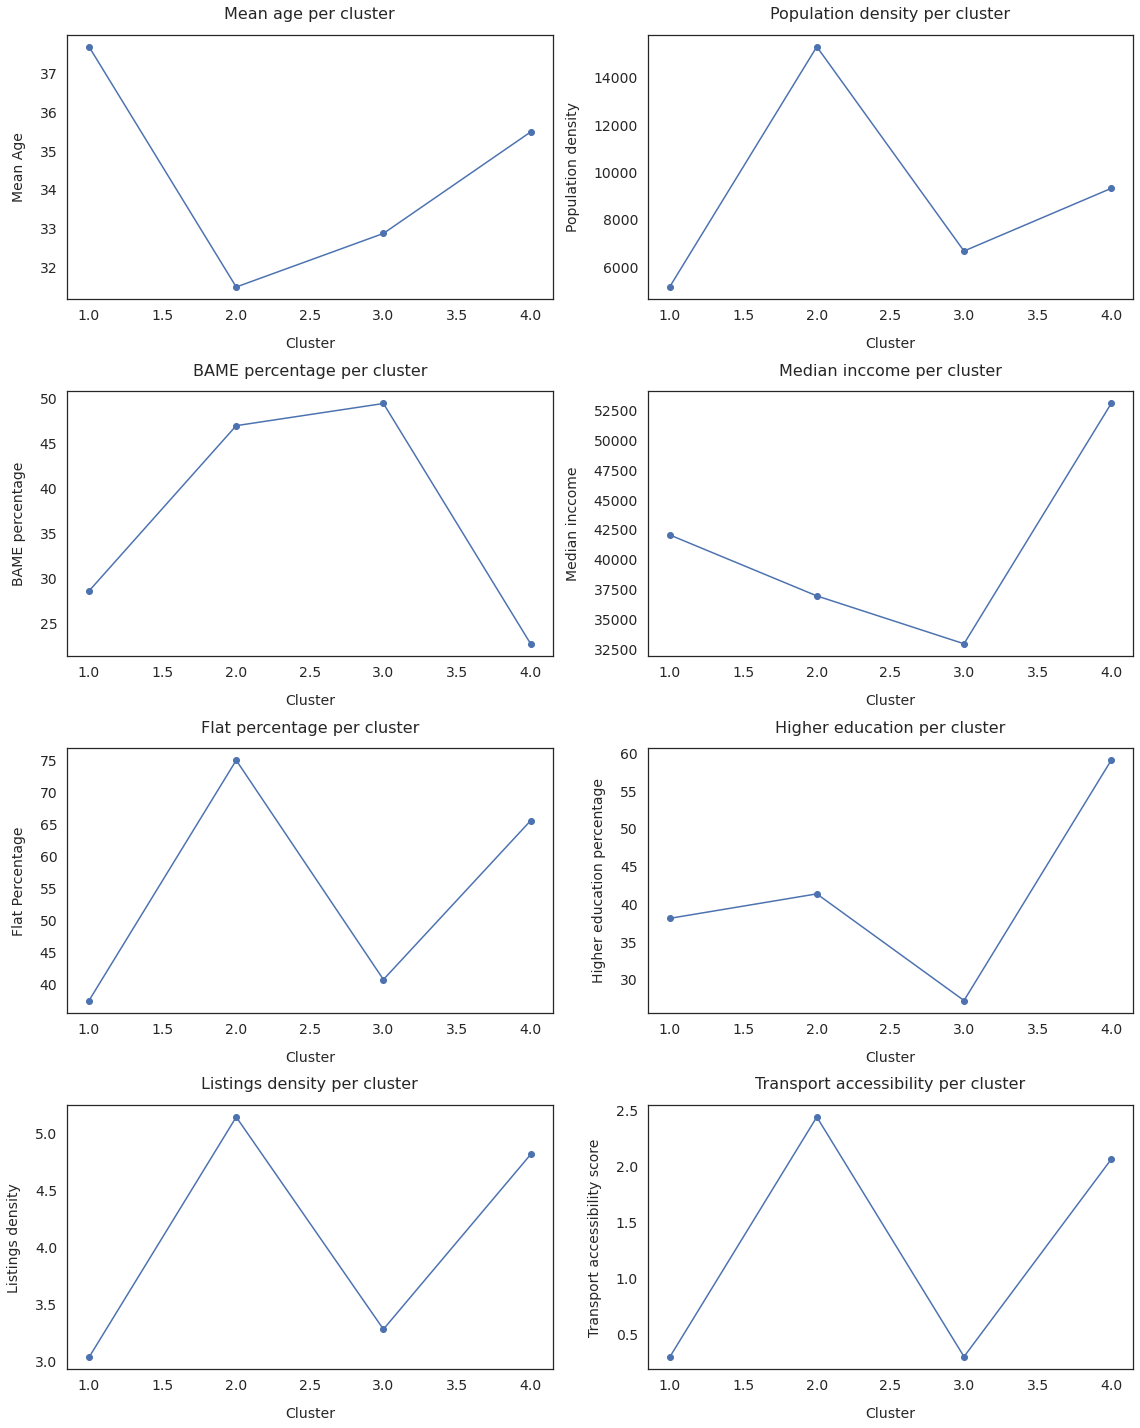

In [88]:
#perform the clustering with the chosen number of clusters
kmeans_method = KMeans(n_clusters = 4,
                        random_state = 22,
                      n_init = 10)
kmeans_method.fit(clustA[columns])


#creating plots for the results to understand the means


#set the titles
titles = [ "Mean age per cluster",
            "Population density per cluster",
            "BAME percentage per cluster",
            "Median inccome per cluster",
            "Flat percentage per cluster",
            "Higher education per cluster",
            "Listings density per cluster",
            "Transport accessibility per cluster" ]
#set the labels
ylabels = ["Mean Age", 
            "Population density",
            "BAME percentage",
            "Median inccome",
            "Flat Percentage",
            "Higher education percentage",
            "Listings density",
            "Transport accessibility score"]
#extract the cluster labels and add these back to the data
labels = kmeans_method.labels_
London_profiles["labels"] = labels
London_profiles["labels"] = London_profiles["labels"] + 1

#create a base plot
fig, ax = plt.subplots(4,2, figsize = (16,20))
#flatten the axis
axis = ax.flatten()

#iterate over each column to create plots for each 
for i, col in enumerate(columns):
    #create an empty dictionary
    col_dict = {}
     #iterate over each label
        
    for label in London_profiles["labels"].unique().tolist():
        #crete a new dataframe for each label
        label_df = London_profiles[London_profiles["labels"] == label]
        #add the mean to the dataframe
        col_dict[label] = label_df[col].mean()
    #convert the dictionary to a dataframe
    column_df = pd.DataFrame.from_dict(col_dict, orient = "index")
    #reset the index
    column_df.reset_index(inplace=True)
    #sort the values by the index
    column_df.sort_values(by = "index", inplace=True)

        #plot the results
    axis[i].plot(column_df["index"], column_df[0],
                marker = "o")
    
    #set the plots up
    axis[i].set_title(titles[i], fontsize = 16, pad = 16)
    axis[i].set_xlabel("Cluster", fontsize = 14, labelpad = 14)
    axis[i].set_ylabel(ylabels[i], fontsize =14, labelpad = 14)
    axis[i].tick_params(axis = "both", labelsize = 14)


#set the layout to tight so no overalp
plt.tight_layout()
 
plt.savefig("Variable_distribution_clusters.png", bbox_inches = 'tight')

In [76]:
#extract the number of wards within each clusterc 
London_profiles["labels"].value_counts()

3    198
1    162
2    148
4    117
Name: labels, dtype: int64

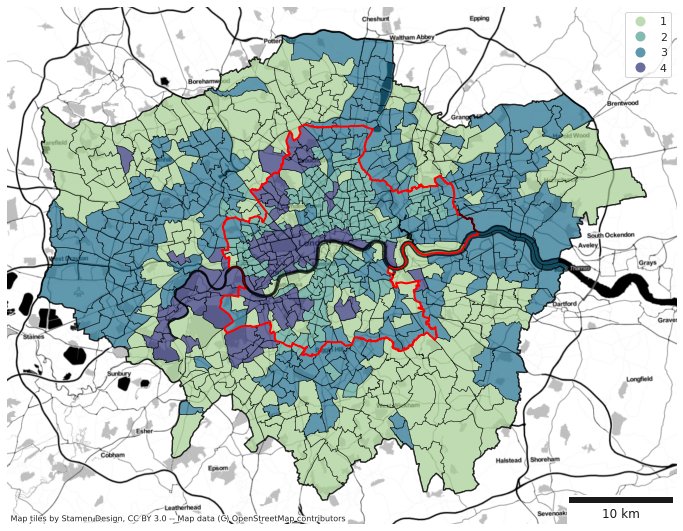

In [89]:
# map the clusters
fig, ax = plt.subplots(1,1, figsize = (12,12))

scale1 = ScaleBar(dx=1,
    location='lower right', 
    label_loc='left', scale_loc='bottom')

ldn_shape.boundary.plot(ax = ax, color = "black", alpha = 0.7)

London_profiles.plot(ax = ax,column='labels',categorical = True, cmap="crest",legend=True,
          edgecolor='black',linewidth=0.6, figsize=(10,8), alpha=0.7)

# add the inner london boundary 
gpd.GeoSeries(boros_il.unary_union).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)

#set the title
#ax.set_title("Geographic distribution of clusters", fontsize = 20,pad = 30)

ctx.add_basemap(ax= ax, crs= boros.crs,
               source = ctx.providers.Stamen.Toner)
ax.set_axis_off()

#add scalebar
ax.add_artist(scale1)

plt.savefig("Cluster_map.png", bbox_inches = 'tight')

For the interpretation of the resulting clusters see the Executive Briefing below

------------------------------------------------------------------------------------------------------

# Executive Briefing



## Table of contents

Executive Summary

Background

Data Analysis

Conclusion

Bibliography

Appendices





## Executive summary


Do certain areas of London trigger the geographic concentration of Airbnb listings across London?

This report seeks to describe and analyse the spread of Airbnb listings in London by identifying common components characterising areas displaying a high concentration of listings. First, visualisations seek to quantify the current picture of Airbnb listings across the city, followed by a categorisation of the Greater London Wards by their concentration of listings (low, medium, high). A subsequent geodemographic classification of the areas attempts to identify patterns explaining the presence or absence of listings. Finally, this paper discusses how these results and similar approaches can inform policies that will regulate Airbnb listings in a targeted manner.

Key findings:

* Airbnb listings numbers, albeit high, have significantly dropped during the Covid 19 pandemic
* As expected, the highest concentration of Airbnb listings is noted in central London areas, but Airbnb listings scatter even to the city’s fringes.
* In a more detailed geodemographic profiling of London areas, the most affected areas are central, affluent with a young population and predominantly white while the least are rural, older and no flats.


## Background



What started as an alternative way of holidays, sharing, and experiencing the local in an authentic and original way, has turned into a booming economy with questionable effects. Airbnb listings have all over the world been professionalised and intensified and are now cluttering cities while the housing crisis remains a major problem.  The fundamental right to a roof is challenged as housing prices rise rapidly across cities, especially in the years after the financial crisis of 2008 (Gleeson, 2021). The notorious housing problem of London (Travers, Sims and Bosetti, 2016) has strongly contributed to spatial inequality and transformed the urban landscape (Shabrina, Arcaute and Batty, 2019) by pushing residents out of inner London to more affordable regions. 

While many factors generate the complicated matter of the housing crisis, research to date shows that Airbnb and similar platforms contribute to rising rent prices (Barron, Kung and Proserpio, no date; Horn and Merante, 2017) and remove available housing from the market by injecting short term rentals in residential areas (Shabrina, Arcaute and Batty, 2022). 

Many have called for policies to control unregulated platforms like Airbnb, but communities, researchers and local authorities have struggled to grasp and interpret the sudden growth and unprecedented model of the sharing economies (Horn and Merante, 2017). This paper argues that in order to successfully and appropriately regulate Airbnb in a city like London, the phenomenon and its complexity need first to be fully understood and studied. Therefore, this analysis will first present the current status of Airbnb listings across London and identify the most affected areas before attempting a more in-depth analysis.

Drawing from the most recent available data on the Inside Airbnb website (October 2021), London currently has a total of just over 67,900 listings. Roughly 20% (13,600 listings) have had a review in the past year, which is used as an indicator for currently active listings. These numbers seem to be in stark contrast with pre-pandemic figures: 80,770 listings in May 2019 (Temperton, 2020). While it is difficult to confirm the accuracy of these numbers since they do not derive from official Airbnb data, it is evident that the Covid 19 pandemic has strongly affected the sharing economy.


![Fig 1](Active_Airbnb_map_comparison_dots2.png)

*Fig.1 - Comparison maps: Airbnb listings in London in 2021 (Data: Inside Airbnb)*


The maps in Figure 1 illustrate the magnitude of the Airbnb listings count across the area of London. Even the outer Boroughs seem to host a considerable number of listings. While the currently active listings (last posted review within the past year) are significantly less, the emerging pattern remains the same: a very high concentration of listings in the centre spread outwards in smaller intensity. More specifically, looking at the density of Airbnb listings across London Boroughs, Figure 2 confirms that inner London Boroughs concentrate most of the listings: Westminster, Kensington and Chelsea, and Tower Hamlets are the three most affected areas, closely followed by Hackney, Islington, and Camden.

![Fig 2](Barplot_Listings_Density_per_Borough.png)

*Fig.2 - Barplot: Airbnb listings Density per London Borough(2021) (Data: Inside Airbnb)*


## Data Analysis

This analysis will use the listings density (active and inactive) as the measure of spatial penetration of Airbnb listings in London. However, the London Boroughs are relatively large spatial units that do not capture more fine-grained variation across the city's urban fabric. Therefore, the analysis will be based on smaller spatial units, the Greater London Wards. 

![Fig 3](Log Airbnb_density.png)

*Fig.3 - Airbnb listings density(log) in London in 2021 (Data: Inside Airbnb)*


Plotting the Log transformed listings density across the London Wards (Figure 3) reveals:

* High concentration of listings in the central north and west parts of London
* Medium concentration of listings in the immediately surrounding areas and mostly within the inner London division with a light but a noticeable shift towards the west. 
* Low concentration of listings in Outer London.  

While the concentration of listings in central London is certainly expected and explained by the attractiveness of these areas to tourists, in terms of proximity to major sights of the city, the rather surprising expansion of listings towards even the outer areas of the city have been noted and studied in previous research. (Quattrone et al., 2016; Shabrina, Arcaute and Batty, 2019) 

In the attempt to better understand where and why listings are concentrating, this analysis employs a form of statistical clustering known as K-Means to group the London Wards based on the concentration of Airbnb listings and variables deriving from the London Wards Profiles from the London Datastore that provides key summary measures on a multitude of categories such as population, diversity, and housing. 


![Fig 4](table.PNG)

*Fig.4 - Table listing the variables used (Data: London Ward Profiles, Inside Airbnb)*

![Fig 5](Variables_maps.png)

*Fig.5 - Distribution of variables across London (Data: London Ward Profiles, Inside Airbnb)*


The selection of the variables as listed in Figure 4, whilst not exhaustive, aims to capture a range of geodemographic, social, and economic characteristics of the subregions following similar studies (Quattrone et al., 2016, 2018).

The distribution of the data is heavily skewed in some instances and with different ranges and units (Appendix A), which requires standardisation so that none of the variables dominates the classification process. The number of clusters is set to 4 based on the results from the Elbow and Silhouette plot (Appendix B)

Evaluating the distribution of each variable per cluster (Appendix C) in conjunction with the geographic distribution of the clusters across London (Figure 8), the resulting clusters can be interpreted as (LOW, MEDIUM, HIGH indicate the concentration of listings):

**Cluster 1:  LOW - suburban middle class**

These are suburban areas, in the outer edges of London, where population density is low, and few houses are flats and transport connections are bad. The population is older, predominantly white, with average income and low higher education levels.

**Cluster 2:  HIGH - densely populated diverse inner London**

Mostly inner London areas with good transport links, with some exceptions. These areas have a high population density together with a high concentration of flats. Characterised by younger, diverse population with an average income and average higher education levels. 

**Cluster 3: MEDIUM - affluent and attractive city areas**

Almost entirely inner London areas with relatively good transport links. Medium population density levels as well as medium flat concentration. The population age is average, predominantly white with high income and high education levels. 

**Cluster 4: LOW - deprived outer areas**

Areas just outside inner London, with exceptions, that have bad transport links. Medium population density levels and few flats. The population here is mostly Black, Asian and Minority Ethnic with low income and education levels.


![Fig 6](Cluster_map.png)

*Fig.6 - Distribution of variables across London (Data: London Ward Profiles, Inside Airbnb)*


## Conclusion

The classification of London wards suggests that Airbnb listings are concentrated not only in central areas with good transport links but also in areas with young, white, well-off residents and where flats are more frequent than other types of housings. These findings align with Quattrone et al. regression and prediction models, which identify central areas with young and talented people most prone to high Airbnb listings concentration.  (Quattrone et al., 2018)

This rather simple and generic classification of the London areas can form the basis for a much more detailed and complicated analysis, implementing different methods such as a multiple linear regression while testing for spatial autocorrelation. Using a more extensive set of variables and perhaps even smaller spatial units might refine the results and produce new insights.

While the results strongly depend on the researcher’s choices, methods, and assumptions, it is essential to note that the data themselves have significant limitations: the London Profiles data extracted from the 2011 census is now outdated, while the Inside Airbnb data has questionable accuracy, and any interpretation needs to bear in mind the still ongoing Covid 19 pandemic.

The findings indicate that the policies and regulations imposed on the sharing economy need to take into account the variations in listings concentration and neighbourhood characteristics which will help protect the most susceptible areas. Creating incentives for either hosts to register their short-term lets on a government/local authority platform or Airbnb to share their data so that an accurate and valid database can be created informing the much-needed further research on this topic. 


# Bibliography

[Barron, K., Kung, E. and Proserpio, D. (no date) The Effect of Home-Sharing on House Prices and Rents: Evidence from Airbnb. Available at: https://ssrn.com/abstract=3006832.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3006832)

[Gleeson, J. (2021) GLA Housing and Land Housing in London 2021. Available at: www.london.gov.uk.](https://data.london.gov.uk/download/housing-london/ae8ad049-69e7-42cf-a2d3-86f4feff2f52/Housing%20in%20London%202021%20v2.pdf)

[Horn, K. and Merante, M. (2017) “Is home sharing driving up rents? Evidence from Airbnb in Boston,” Journal of Housing Economics, 38, pp. 14–24. doi:10.1016/j.jhe.2017.08.002.](https://www.sciencedirect.com/science/article/abs/pii/S1051137717300876)

[Inside Airbnb,2021. Available at: http://insideairbnb.com/get-the-data.html (Accessed: 22 December 2021).](http://insideairbnb.com/get-the-data.html)

[London Datastore, 2021, Ward Profiles and Atlas. Available at: https://data.london.gov.uk/dataset/ward-profiles-and-atlas (Accessed: 22 December 2021).](https://data.london.gov.uk/dataset/ward-profiles-and-atla)

[Quattrone, G. et al. (2016) “Who benefits from the ‘sharing’ economy of airbnb?,” in 25th International World Wide Web Conference, WWW 2016. International World Wide Web Conferences Steering Committee, pp. 1385–1393. doi:10.1145/2872427.2874815.](https://www.researchgate.net/publication/301874810_Who_Benefits_from_the_Sharing_Economy_of_Airbnb)

[Quattrone, G. et al. (2018) “Analyzing and predicting the spatial penetration of Airbnb in U.S. cities,” EPJ Data Science, 7(1). doi:10.1140/epjds/s13688-018-0156-6.](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-018-0156-6)

[Shabrina, Z., Arcaute, E. and Batty, M. (2019) “Airbnb’s disruption of the housing structure in London.” Available at: http://arxiv.org/abs/1903.11205.](http://arxiv.org/abs/1903.11205)

[Shabrina, Z., Arcaute, E. and Batty, M. (2022) “Airbnb and its potential impact on the London housing market,” Urban Studies, 59(1), pp. 197–221. doi:10.1177/0042098020970865.](https://journals.sagepub.com/doi/full/10.1177/0042098020970865)

[Travers, T., Sims, S. and Bosetti, N. (no date) HOUSING AND INEQUALITY IN LONDON. Available at: www.centreforlondon.org.](www.centreforlondon.org)

[Temperton, J. (2020) Airbnb has devoured London – and here’s the data that proves it. Available at: https://www.wired.co.uk/article/airbnb-london-short-term-rentals (Accessed: 04 January 2022).](https://www.wired.co.uk/article/airbnb-london-short-term-rentals)


# Appendices

### Appendix A

![Fig 6](Variables_distribution_hist.png)


### Appendix B

<figure>
<img src="Silhouette_elbow_plot.png" alt="Trulli" style="width:80%">
<figcaption align = "centre"><b> Silhouette and Elbow plot </b></figcaption>
</figure>

### Appendix C

![Fig 6](Variable_distribution_clusters.png)
